# Parametric shape optimization with differentiable FEM simulation

<div class="admonition note alert alert-warning">
<p class="admonition-title">Note</p>

All examples are expected to run from the `examples/<example_name>` directory of the [Tesseract-JAX repository](https://github.com/pasteurlabs/tesseract-jax).
</div>

In this example, you will learn how to:
1. Build a Tesseract that wraps a differentiable finite-element solver from [jax-fem](https://github.com/deepmodeling/jax-fem).
2. Build a Tesseract that uses finite differences under the hood to enable differentiability of a non-autodifferentiable geometry operation (computing a signed distance field from a 3D model).
3. Compose both Tesseracts with Tesseract-JAX to create a pipeline that can be used for differentiable shape optimization.
4. Perform gradient-based optimization using `optax` on the Tesseract-JAX pipeline.

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material. The structure is parametrized by N bars, each of which has M piecewise linear segments. We seek the ideal configuration of the $y$-coordinates of the vertices that connect those bar segments. This notebook is based on the [2D topology optimization example](https://github.com/deepmodeling/jax-fem/blob/main/docs/source/learn/topology_optimization.ipynb) from `jax-fem`, but we solve the problem using a parametric approach instead.

**That is, we use end-to-end automatic differentiation (AD) through several components to optimize the design variables directly with respect to (simulated) performance of the design.**

The design space is defined using a geometry library called PyVista, which does not support automatic differentiation. However, we can enable differentiability of this operation by using a finite difference approximation of the Jacobian matrix.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(\rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables (the $y$-coordinates of the vertices).

### AD and Tesseracts

![Parametric shape optimization](illustration.png)

Since we want use a gradient based optimizer, we need to compute the gradient of the compliance with respect to the design variables. Hence we are interested in the following derivative:

$$
\begin{equation}
\frac{\partial f}{\partial\theta} = \frac{\partial f}{\partial \rho} \cdot \frac{\partial \rho}{\partial g} \cdot \frac{\partial g}{\partial\theta}
\end{equation}
$$

Note that each term is a (Jacobian) matrix. With modern AD libraries such as [JAX](https://github.com/jax-ml/jax), backpropagation uses the vector-Jacobian-product to pull back the gradients over the entire pipeline, without ever materializing Jacobian matrices. This is a powerful feature, but it typically requires that the entire pipeline is implemented in a single monolithic application – which can be cumbersome and error-prone, and does not scale well to large applications or compute needs.

With Tesseracts, we wrap each function in a separate module and then compose them together. To enable differentiability, we also define AD-relevant endpoints, such as the vector-Jacobian product, inside each Tesseract module (`tesseract_api.py`).

To learn more about building and running Tesseracts, please refer to the [Tesseract documentation](https://docs.pasteurlabs.ai/projects/tesseract-core/latest/).

### Setup

Let's install the required packages and build the two Tesseract images. Building the Tesseracts can take a few minutes as they are Docker containers with quite a few dependencies.

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

## Step 1: Build + inspect used Tesseracts

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# print("Tesseract built successfully.")

### Explore Design Space Tesseract

First, let's import the Tesseract Core library and start a server for the design space Tesseract, which is equivalent to the function $g$ in the equation above.

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract

In [4]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("design_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [5]:
n_chains = 2
n_edges_per_chain = 2
bar_radius = 0.5

Lx = 10
Ly = 5
Lz = 5
Nx = 15
Ny = 15
Nz = 15

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    # add an offset
    print(chain / n_chains * Ly - Ly / 2)
    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

ERROR:2025-10-30 16:15:52,740:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH


-2.5
0.0
Number of vertices: 180
Number of faces: 352
SDF shape: (15, 15, 15)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

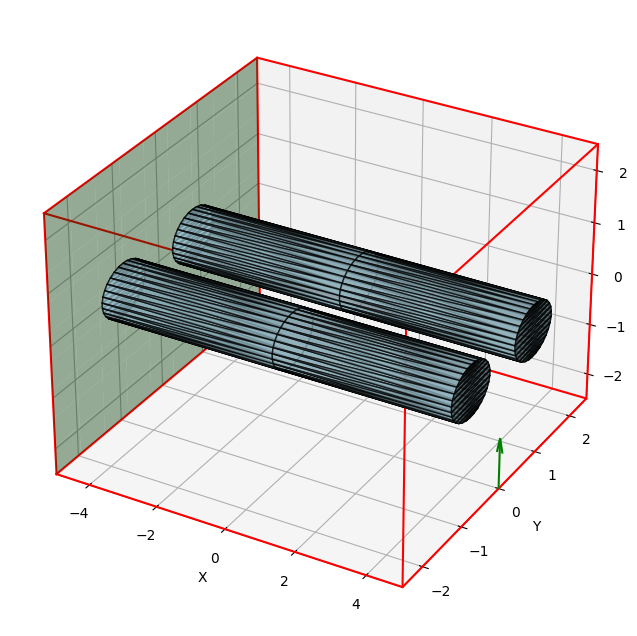

In [6]:
def plot_mesh(mesh, save_path=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )
    # add red bounding box to indicate domain
    ax.plot(
        [-Lx / 2, Lx / 2, Lx / 2, -Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2, Ly / 2, Ly / 2, -Ly / 2],
        -Lz / 2 * jnp.ones(5),
        color="red",
    )
    ax.plot(
        [-Lx / 2, Lx / 2, Lx / 2, -Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2, Ly / 2, Ly / 2, -Ly / 2],
        Lz / 2 * jnp.ones(5),
        color="red",
    )
    ax.plot(
        [-Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [Lx / 2, Lx / 2],
        [-Ly / 2, -Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [Lx / 2, Lx / 2],
        [Ly / 2, Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [-Lx / 2, -Lx / 2],
        [Ly / 2, Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10))
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")
    
    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)

plot_mesh(mesh)

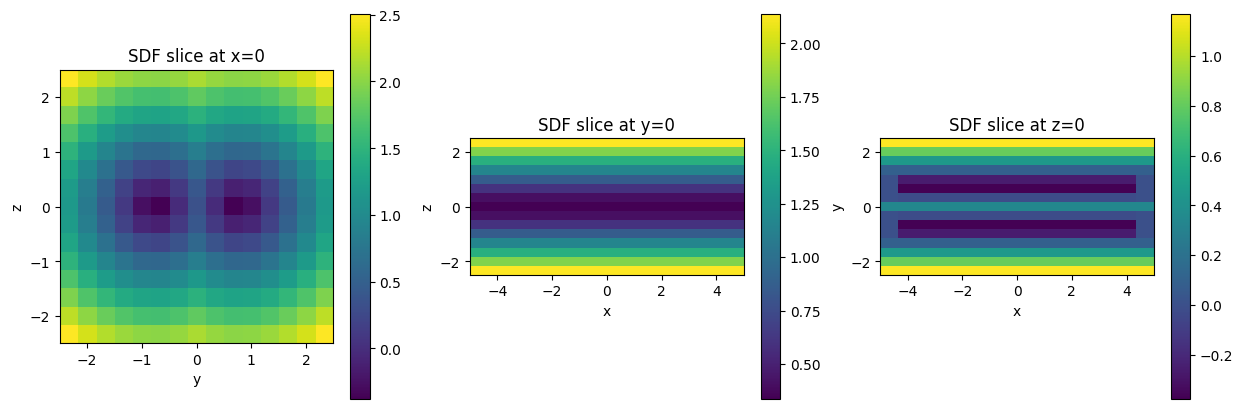

In [7]:
# visualize the sdf by plotting a slice through each axis
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(
    sdf[Nx // 2, :, :].T, extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2), origin="lower"
)
axs[0].set_title("SDF slice at x=0")
axs[0].set_xlabel("y")
axs[0].set_ylabel("z")
# add colorbar
plt.colorbar(
    axs[0].imshow(
        sdf[Nx // 2, :, :].T, extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2), origin="lower"
    ),
    ax=axs[0],
)

axs[1].imshow(
    sdf[:, Ny // 2, :].T, extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2), origin="lower"
)
axs[1].set_title("SDF slice at y=0")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")
# add colorbar
plt.colorbar(
    axs[1].imshow(
        sdf[:, Ny // 2, :].T, extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2), origin="lower"
    ),
    ax=axs[1],
)

axs[2].imshow(
    sdf[:, :, Nz // 2].T, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower"
)
axs[2].set_title("SDF slice at z=0")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

# add colorbar
plt.colorbar(
    axs[2].imshow(
        sdf[:, :, Nz // 2].T, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower"
    ),
    ax=axs[2],
)

Instead of calling the apply endpoint we can also call the vector-Jacobian product endpoint which is used for backpropagation (also called reverse-mode AD). This endpoint computes the derivative of the SDF with respect to the design variables, which is useful for gradient-based optimization. Hence we set the `vjp_inputs` to `bar_params` and the `vjp_outputs` to `sdf`, to indicate that we want to differentiate the SDF with respect to the shape parameters. 

In [8]:
grad = design_tess.vector_jacobian_product(
    inputs={
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Nz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        "normalize_jacobian": True,
        "normalize_vjp": False,
    },
    vjp_inputs=["bar_params"],
    vjp_outputs=["sdf"],
    cotangent_vector={"sdf": jnp.ones((Nx, Ny, Nz), dtype=jnp.float32)},
)["bar_params"]

print("Gradient shape:", grad.shape)
print(grad.std())

Gradient shape: (2, 3, 3)
0.015480794


Above we manually supplied all the relevant information regarding the VJP inputs, outputs, and cotangent vector. To make this easier, we can use the [Tesseract-JAX](https://github.com/pasteurlabs/tesseract-jax) library. Tesseract-JAX automatically registers Tesseracts as JAX primitives, which allows us to use JAX as an AD engine over functions that mix and match Tesseracts with regular JAX code. We can see this in action by using the `jax.vjp` function over `tesseract_jax.apply_tesseract`.

In [9]:
import jax

from tesseract_jax import apply_tesseract

primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 0.01,  # Smoothing parameter for SDF computation,
            "normalize_jacobian": True,
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (2, 3, 3)


In [10]:
# Lets figure out a good epsilon value for FD jacobian computation
epsilons = jnp.logspace(-6, 0, 6)
mean_grads = []
std_grads = []

for i in range(len(epsilons)):
    eps = epsilons[i]
    primal, vjp_fun = jax.vjp(
        lambda params, eps=eps: apply_tesseract(
            design_tess,
            {
                "bar_params": params,
                "bar_radius": bar_radius,
                "Lx": Lx,
                "Ly": Ly,
                "Lz": Lz,
                "Nx": Nx,
                "Ny": Ny,
                "Nz": Nz,
                "epsilon": eps.item(),  # Smoothing parameter for SDF computation,
                "normalize_jacobian": True,
            },
        )["sdf"],
        initial_params,
    )

    grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

    mean_grads.append(jnp.mean(jnp.abs(grad)))
    std_grads.append(jnp.std(grad))


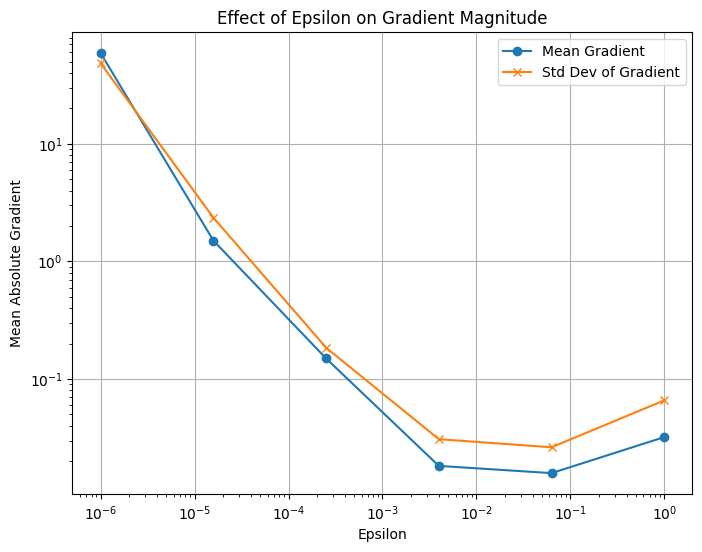

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, mean_grads, marker="o")
plt.plot(epsilons, std_grads, marker="x")
plt.xlabel("Epsilon")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Mean Absolute Gradient")
plt.title("Effect of Epsilon on Gradient Magnitude")
plt.grid(True)
plt.legend(["Mean Gradient", "Std Dev of Gradient"])

### Define mapping from SDF to Density Field

Now that we have the signed distance field (SDF) from the design space, we can proceed to compute the *density field*, which is what the FEM solver expects. That is, we need to define a function $\rho$ that maps the SDF to a density value. This function needs to be smooth and differentiable to ensure that the optimization process can effectively navigate the design space. We use a parametrized sigmoid function, which ensures that the density values are bounded between 0 and 1. Here, $s$ is the slope of the sigmoid and $\varepsilon$ is the offset. The parameters $s$ and $\varepsilon$ can be adjusted to control the steepness and position of the transition between 0 and 1 in the density field.

$$
\begin{equation}
    \rho(\text{SDF}) = \frac{1}{1 + e^{s \cdot \text{SDF} - \varepsilon}}
\end{equation}
$$

Since this function is straightforward to implement, we can directly use the JAX library to define it.

In [12]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 6.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))

To verify the conversion, we can visualize the density field:

Rho shape: (15, 15, 15)
Rho min/max: 3.2785982e-07 0.9144546


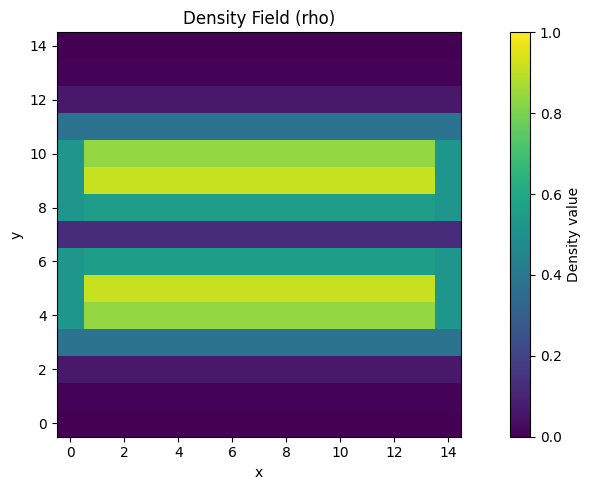

In [13]:
rho = sdf_to_rho(sdf)
print("Rho shape:", rho.shape)
print("Rho min/max:", jnp.min(rho), jnp.max(rho))
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(rho[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1)
ax.set_title("Density Field (rho)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="Density value")
plt.tight_layout()

In [14]:
def sizing_field(
    sdf : jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 10.0
):
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.
    Returns:
        Sizing field values.
    """
    normalized_sdf = jnp.clip(sdf * scale + 0.5, 0.0, 1.0)
    return min_size + (max_size - min_size) * normalized_sdf

Sizing field shape: (15, 15, 15)


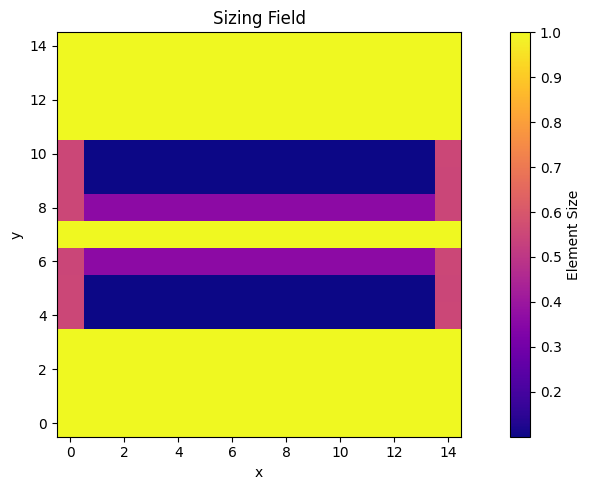

In [15]:
sizing = sizing_field(sdf)
print("Sizing field shape:", sizing.shape)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(sizing[:, :, Nz // 2].T, origin="lower", cmap="plasma")
ax.set_title("Sizing Field")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="Element Size")
plt.tight_layout()

In [ ]:
from jax.scipy.interpolate import RegularGridInterpolator

def create_hex(
    Lx: float,
    Ly: float,
    Lz: float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """ 
    Create a single HEX8 mesh of a cuboid domain.
    """

    # Define the 8 corner points of the hexahedron
    points = jnp.array([
        [-Lx / 2, -Ly / 2, -Lz / 2],  # Point 0
        [ Lx / 2, -Ly / 2, -Lz / 2],  # Point 1
        [ Lx / 2,  Ly / 2, -Lz / 2],  # Point 2
        [-Lx / 2,  Ly / 2, -Lz / 2],  # Point 3
        [-Lx / 2, -Ly / 2,  Lz / 2],  # Point 4
        [ Lx / 2, -Ly / 2,  Lz / 2],  # Point 5
        [ Lx / 2,  Ly / 2,  Lz / 2],  # Point 6
        [-Lx / 2,  Ly / 2,  Lz / 2],  # Point 7
    ], dtype=jnp.float32)

    # Define the hexahedron cell using the point indices
    hex_cells = jnp.array([
        [0, 1, 2, 3, 4, 5, 6, 7]  # Single HEX8 element
    ], dtype=jnp.int32)

    return points, hex_cells

def vectorized_subdivide_hex_mesh(
    hex_cells: jnp.ndarray, # (n_hex, 8)
    pts_coords: jnp.ndarray, # (n_points, 3)
    mask : jnp.ndarray # (n_hex,) boolean array indicating which hexes to subdivide
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Vectorized subdivision of HEX8 mesh.

    This method introduces duplicates of points that should later be merged.

    A hexahedron is constructed as follows:
             3 -------- 2
         /|         /|
        7 -------- 6 |
        | |        | |
        | 0 -------|-1
        |/         |/
        4 -------- 5
    
    Axis orientation:
        y
        |
        |____ x
       /
      /
     z

    """

    n_hex = hex_cells.shape[0]
    n_new_pts = (8 * 8) * n_hex  # 8 corners per new hex, 8 new hexes per old hex

    new_pts_coords = jnp.zeros((n_new_pts, 3), dtype=pts_coords.dtype)
    new_hex_cells = jnp.zeros((n_hex * 8, 8), dtype=hex_cells.dtype)

    voxel_sizes = jnp.abs(pts_coords[hex_cells[:, 6]] - pts_coords[hex_cells[:, 0]])
    
    center_points = jnp.mean(pts_coords[hex_cells], axis=1)  # (n_hex, 3)
    offsets = jnp.array([
        [-0.25, -0.25, -0.25],
        [0.25, -0.25, -0.25],
        [0.25, 0.25, -0.25],
        [-0.25, 0.25, -0.25],
        [-0.25, -0.25, 0.25],
        [0.25, -0.25, 0.25],
        [0.25, 0.25, 0.25],
        [-0.25, 0.25, 0.25],
    ]) * voxel_sizes

    for cell in range(8):
        center = center_points + offsets[cell]

        for corner in range(8):
            new_pts_coords = new_pts_coords.at[
                jnp.arange(n_hex) * 64 + cell * 8 + corner
            ].set(
                center + offsets[corner]
            )

            new_hex_cells = new_hex_cells.at[
                jnp.arange(n_hex) * 8 + cell, corner
            ].set(
                jnp.arange(n_hex) * 64 + cell * 8 + corner
            )

    def reindex_and_mask(
        coords: jnp.ndarray,
        cells: jnp.ndarray,
        keep_mask: jnp.ndarray
    ) -> tuple[jnp.ndarray, jnp.ndarray]:
        """Reindex points and cells based on mask.
        """
        # map mask to points
        point_mask = jnp.zeros(coords.shape[0], dtype=jnp.float32)
        point_mask = point_mask.at[cells.flatten()].add(keep_mask.repeat(8))
        # Reindex new points and cells based on mask
        index_offset = jnp.cumsum(jnp.logical_not(point_mask))
        cells = cells - index_offset.at[cells.flatten()].get().reshape(cells.shape)

        # apply mask to keep only subdivided hexes
        coords = coords.at[keep_mask.repeat(8)].get()
        cells = cells.at[keep_mask].get()

        return coords, cells

    new_pts_coords, new_hex_cells = reindex_and_mask(
        new_pts_coords, new_hex_cells, mask.repeat(8)
    )

    old_pts_coords, old_hex_cells = reindex_and_mask(
        pts_coords, hex_cells, jnp.logical_not(mask)
    )

    old_hex_cells = old_hex_cells + new_pts_coords.shape[0]

    combined_pts_coords = jnp.vstack([new_pts_coords, old_pts_coords])
    combined_hex_cells = jnp.vstack([new_hex_cells, old_hex_cells])

    return combined_pts_coords, combined_hex_cells

def remove_duplicate_points(
    pts_coords: jnp.ndarray,
    hex_cells: jnp.ndarray
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Remove duplicate points from the mesh and update hex cell indices.
    """

    unique_pts, inverse_indices = jnp.unique(pts_coords, axis=0, return_inverse=True)
    updated_hex_cells = inverse_indices[hex_cells]

    return unique_pts, updated_hex_cells

def recursive_subdivide_hex_mesh(
    hex_cells: jnp.ndarray,
    pts_coords: jnp.ndarray,
    sizing_field: jnp.ndarray,
    levels: int,
    Lx: float,
    Ly: float,
    Lz: float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Recursively subdivide HEX8 mesh.

    Args:
        hex_cells: (n_hex, 8) array of hexahedron cell indices.
        pts_coords: (n_points, 3) array of point coordinates.
        sizing_field: Sizing field values at each point. 
            Must be 2^levels in each dimension.
        levels: Number of subdivision levels.

    Returns:
        Subdivided points and hex cells.
    """

    # lets build the kd-tree for fast nearest neighbor search
    xs = jnp.linspace(-Lx / 2, Lx / 2, sizing_field.shape[0])
    ys = jnp.linspace(-Ly / 2, Ly / 2, sizing_field.shape[1])
    zs = jnp.linspace(-Lz / 2, Lz / 2, sizing_field.shape[2])

    interpolator = RegularGridInterpolator(
        (xs, ys, zs), sizing_field, method="nearest", bounds_error=False, fill_value=jnp.max(sizing_field)
    )

    for _ in range(levels):
        voxel_sizes = jnp.max(jnp.abs(pts_coords[hex_cells[:, 6]] - pts_coords[hex_cells[:, 0]]), axis=1)
        sizing_values = interpolator(pts_coords[hex_cells].mean(axis=1))
        subdivision_mask = voxel_sizes > sizing_values
        pts_coords, hex_cells = vectorized_subdivide_hex_mesh(
            hex_cells, pts_coords, subdivision_mask
        )

    return pts_coords, hex_cells

initial_pts, initial_hex_cells = create_hex(Lx, Ly, Lz)

pts, hex_cells = recursive_subdivide_hex_mesh(
    initial_hex_cells, initial_pts, sizing, levels=3, Lx=Lx, Ly=Ly, Lz=Lz
)

# print("Initial points: ", initial_pts)
# print("Initial hex cells: ", initial_hex_cells)

# subdivision_mask = jnp.array([True], dtype=bool)
# pts_lvl_1, hex_lvl_1 = vectorized_subdivide_hex_mesh(
#     initial_hex_cells, initial_pts, subdivision_mask
# )
# n_pts_lvl_1 = pts_lvl_1.shape[0]

# # pts_lvl_1, hex_lvl_1 = remove_duplicate_points(pts_lvl_1, hex_lvl_1)
# # print(f"Level 1 points reduced from {n_pts_lvl_1} to {pts_lvl_1.shape[0]} after removing duplicates.")

# # print("Level 1 points shape: ", pts_lvl_1.shape)
# # print("Level 1 hex cells shape: ", hex_lvl_1.shape)

# subdivision_mask = jnp.array([False, True, False, False, True, False, False, False], dtype=bool)
# # subdivision_mask = jnp.array([True] * 8, dtype=bool)
# pts_lvl_2, hex_lvl_2 = vectorized_subdivide_hex_mesh(
#     hex_lvl_1, pts_lvl_1, subdivision_mask
# )

# n_pts_lvl_2 = pts_lvl_2.shape[0]
# pts_lvl_2, hex_lvl_2 = remove_duplicate_points(pts_lvl_2, hex_lvl_2)
# print(f"Level 2 points reduced from {n_pts_lvl_2} to {pts_lvl_2.shape[0]} after removing duplicates.")

# print("Level 2 points shape: ", pts_lvl_2.shape)
# print("Level 2 hex cells shape: ", hex_lvl_2.shape)

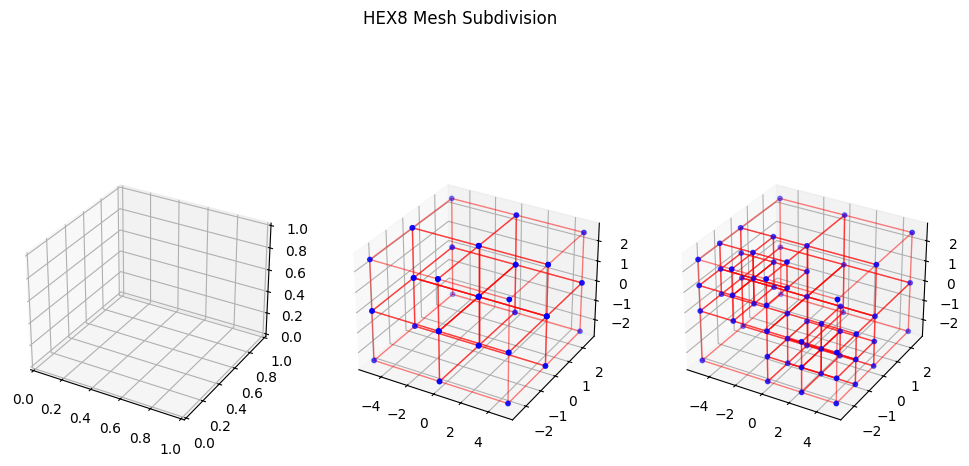

In [42]:
def plot_hex8_mesh(
    pts_coords: jnp.ndarray,  # (n_points, 3)
    hex_cells: jnp.ndarray,  # (n_hex, 8)
    ax=None
):
    ax.scatter(
        pts_coords[:, 0], pts_coords[:, 1], pts_coords[:, 2], color="blue", s=10
    )

    # Plot hex cells
    for cell in hex_cells:
        # Get the coordinates of the cell's corners
        corners = pts_coords[cell]
        # print(f"Cells {cell}: Corners {corners}")
        for corner in [
            (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
            (4, 5), (5, 6), (6, 7), (7, 4),  # top face
            (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
        ]:
            hexagon = [corners[corner[0]], corners[corner[1]]]
            ax.plot3D(*zip(*hexagon), color="red", linewidth=1, alpha=0.5)


fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("HEX8 Mesh Subdivision")

# plot_hex8_mesh(initial_pts, initial_hex_cells, ax=axs[0])
plot_hex8_mesh(pts_lvl_1, hex_lvl_1, ax=axs[1])
plot_hex8_mesh(pts_lvl_2, hex_lvl_2, ax=axs[2])


### FEM Tesseract

Now that we have a density field, we compute the *compliance* of the structure (~stiffness against deformation). That is, we find the most stable configuration of the structure under a given load. The compliance is computed using a finite element method (FEM) solver, which is implemented in the FEM Tesseract. The FEM Tesseract takes the density field as input and returns the compliance of the structure.

The compliance Tesseract is using the jax-fem finite element library, which is fully auto-differentiable. Inside the Tesseract the boundary conditions are already hard coded, where the entire left side is subject to a Dirichlet boundary condition and bottom right side to a Neumann boundary condition.

In [12]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()
# check if jax is using the gpu
x = jnp.array([1.0, 2.0, 3.0])
print("JAX is using device:", x.device)
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

JAX is using device: TFRT_CPU_0
       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



[10-24 13:58:59][INFO] jax_fem: pyamgx not installed. AMGX solver disabled.


In [13]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.reshape(rho, (Nx * Ny * Nz, 1)),
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[10-24 13:59:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[10-24 13:59:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[10-24 13:59:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[10-24 13:59:03][DEBUG] jax_fem: Done pre-computations, took 1.0981776714324951 [s]
[10-24 13:59:03][INFO] jax_fem: Solving a problem with 3375 cells, 4096x3 = 12288 dofs.
[10-24 13:59:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[10-24 13:59:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:04][DEBUG] jax_fem: Start timing
[10-24 13:59:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.4424 seconds
[10-24 13:59:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:05][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:05][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 13:59:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:07][DEBUG] jax_fem: l_2 res = 8.481891251476728e-10, relative l_2 res = 2.835085795783107e-11


TFRT_CPU_0
cpu


[10-24 13:59:08][INFO] jax_fem: Solve took 3.8309383392333984 [s]
[10-24 13:59:08][INFO] jax_fem: max of dofs = 4.016633382932671
[10-24 13:59:08][INFO] jax_fem: min of dofs = -13.205126250172349


Compliance: 2008.0183


## Step 2: Gradient-based parametric shape optimization

Now that we have all the components of the pipeline, we can compose them together and define the loss function for the optimization. The loss function is simply the compliance of the structure, which we can compute by applying the FEM Tesseract to the density field obtained from the design space Tesseract.

**This function looks trivial, but it is actually a complex pipeline that involves several components, each of which is differentiable.** The complexity is hidden behind the Tesseract implementation, which allows us to compose the components together and use them as a single function, without worrying about the details of the implementation.

In [15]:
def loss(params: jnp.ndarray) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # -- Tess 1 (design) --
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-2,  # epsilon for finite difference
            "normalize_jacobian": True,
        },
    )["sdf"]

    # -- Local JAX code --
    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf)

    # -- Tess 2 (FEM) --
    # Compute structural compliance via finite element analysis
    compliance = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.reshape(rho, (Nx * Ny * Nz, 1)),  # Flatten for FEM solver
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
        },
    )["compliance"]
    return compliance

Now we can use JAX's `grad` function to compute the gradient of the compliance with respect to the design variables. We use a simple gradient descent optimizer to perform the optimization towards a local minimum. This is not a very sophisticated optimization approach, but it serves as a good starting point. The optimization process will take a few minutes to run.

In [16]:
import optax

optmizer = optax.adam(learning_rate=0.08)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.jit(jax.value_and_grad(loss))

for i in range(60):

    loss_value, grads = grad_fn(params)
    print("Grad norm:", jnp.linalg.norm(grads))
    print(grads)
    print(params)
    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[10-24 13:59:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:28][DEBUG] jax_fem: Start timing
[10-24 13:59:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 13:59:28][DEBUG] jax_fem: Creating sparse matrix with scipy...


[10-24 13:59:29][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:29][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0344 seconds
[10-24 13:59:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:30][DEBUG] jax_fem: l_2 res = 7.90037331260804e-10, relative l_2 res = 2.6407124892174694e-11
[10-24 13:59:30][INFO] jax_fem: Solve took 1.8663933277130127 [s]
[10-24 13:59:30][INFO] jax_fem: max of dofs = 4.02192173708327
[10-24 13:59:30][INFO] jax_fem: min of dofs = -13.295266179049108
[10-24 13:59:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:30][DEBUG] jax_fem: Start timing
[10-24 13:59:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 13:59:30][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 13:59:30][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:30][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[10-24 13:59:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:32][DEBUG] jax_fem: l_2 res = 7.90037331260804e-10, relative l_2 res = 2.6407124892174694e-11
[10-24 13:59:32][INFO] jax_fem: Solve took 1.9181277751922607 [s]
[10-24 13:59:32][INFO] jax_fem: max of dofs = 4.02192173708327
[10-24 13:59:32][INFO] jax_fem: min of dofs = -13.295266179049108


cpu


[10-24 13:59:33][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 13:59:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.4313 seconds
[10-24 13:59:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[10-24 13:59:36][DEBUG] jax_fem: Computing cell residual...
[10-24 13:59:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.3500 seconds


Grad norm: 1.33167
[[[ 0.0000000e+00  1.4202994e-01 -3.5893339e-01]
  [ 0.0000000e+00 -4.5503414e-01 -3.3642668e-01]
  [ 0.0000000e+00 -7.7379960e-01 -1.3445179e-03]]

 [[ 0.0000000e+00  2.2066406e-03 -1.8072897e-01]
  [ 0.0000000e+00 -4.6845847e-01 -4.0011019e-01]
  [ 0.0000000e+00 -5.4140836e-01 -6.6735398e-04]]]
[[[-5.        -0.8333333  0.       ]
  [ 0.        -0.8333333  0.       ]
  [ 5.        -0.8333333  0.       ]]

 [[-5.         0.8333333  0.       ]
  [ 0.         0.8333333  0.       ]
  [ 5.         0.8333333  0.       ]]]


[10-24 13:59:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:38][DEBUG] jax_fem: Start timing
[10-24 13:59:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0380 seconds
[10-24 13:59:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:38][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:38][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Iteration 1, Loss: 2022.87
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0378 seconds
[10-24 13:59:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:40][DEBUG] jax_fem: l_2 res = 8.050930301329327e-10, relative l_2 res = 2.6910364049014016e-11
[10-24 13:59:40][INFO] jax_fem: Solve took 1.8842461109161377 [s]
[10-24 13:59:40][INFO] jax_fem: max of dofs = 3.9465439504637305
[10-24 13:59:40][INFO] jax_fem: min of dofs = -13.197323935747729
[10-24 13:59:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:40][DEBUG] jax_fem: Start timing
[10-24 13:59:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0368 seconds
[10-24 13:59:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 13:59:40][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:40][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 13:59:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:42][DEBUG] jax_fem: l_2 res = 8.050930301329327e-10, relative l_2 res = 2.6910364049014016e-11
[10-24 13:59:42][INFO] jax_fem: Solve took 1.9295203685760498 [s]
[10-24 13:59:42][INFO] jax_fem: max of dofs = 3.9465439504637305
[10-24 13:59:42][INFO] jax_fem: min of dofs = -13.197323935747729
[10-24 13:59:42][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 13:59:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 13:59:42][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 13:59:42][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:44][DEBUG] jax_fem: Computing cell residual...
[10-24 13:59:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds


cpu


[10-24 13:59:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:44][DEBUG] jax_fem: Start timing
[10-24 13:59:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 13:59:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:44][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:44][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.16799249
[[[ 0.         -0.02519229 -0.10250789]
  [ 0.          0.01475739 -0.09789542]
  [ 0.          0.0175216  -0.05786311]]

 [[ 0.         -0.02510418  0.00802056]
  [ 0.          0.01462132  0.05185182]
  [ 0.          0.0047681  -0.00168369]]]
[[[-5.         -0.9133333   0.08      ]
  [ 0.         -0.75333333  0.08      ]
  [ 5.         -0.75333333  0.0799994 ]]

 [[-5.          0.7533337   0.07999999]
  [ 0.          0.9133333   0.08      ]
  [ 5.          0.9133333   0.0799988 ]]]
Iteration 2, Loss: 2005.57
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[10-24 13:59:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:46][DEBUG] jax_fem: l_2 res = 9.655824758391415e-10, relative l_2 res = 3.2274749589981186e-11
[10-24 13:59:46][INFO] jax_fem: Solve took 1.815420150756836 [s]
[10-24 13:59:46][INFO] jax_fem: max of dofs = 3.8723197842677806
[10-24 13:59:46][INFO] jax_fem: min of dofs = -13.238980666056456
[10-24 13:59:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:46][DEBUG] jax_fem: Start timing
[10-24 13:59:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 13:59:46][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 13:59:46][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:46][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0366 seconds
[10-24 13:59:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:48][DEBUG] jax_fem: l_2 res = 9.655824758391415e-10, relative l_2 res = 3.2274749589981186e-11
[10-24 13:59:48][INFO] jax_fem: Solve took 1.8615970611572266 [s]
[10-24 13:59:48][INFO] jax_fem: max of dofs = 3.8723197842677806
[10-24 13:59:48][INFO] jax_fem: min of dofs = -13.238980666056456
[10-24 13:59:48][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 13:59:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0341 seconds
[10-24 13:59:48][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 13:59:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:49][DEBUG] jax_fem: Computing cell residual...
[10-24 13:59:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0424 seconds


TFRT_CPU_0
cpu


[10-24 13:59:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:50][DEBUG] jax_fem: Start timing
[10-24 13:59:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0383 seconds
[10-24 13:59:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:50][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:50][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.34124398
[[[ 0.         -0.05870781 -0.05900062]
  [ 0.          0.00854329 -0.08967312]
  [ 0.          0.02136341 -0.03356465]]

 [[ 0.          0.17687194  0.14670114]
  [ 0.          0.06893449  0.13317396]
  [ 0.          0.06693057  0.1416004 ]]]
[[[-5.         -0.95571136  0.1478973 ]
  [ 0.         -0.70168746  0.14810833]
  [ 5.         -0.70109075  0.1407589 ]]

 [[-5.          0.8079448   0.13091123]
  [ 0.          0.9650538   0.12550505]
  [ 5.          0.96641135  0.15508762]]]
Iteration 3, Loss: 2011.39
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 13:59:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:52][DEBUG] jax_fem: l_2 res = 8.136908768015992e-10, relative l_2 res = 2.7197748457065862e-11
[10-24 13:59:52][INFO] jax_fem: Solve took 1.979337453842163 [s]
[10-24 13:59:52][INFO] jax_fem: max of dofs = 3.7707986210333884
[10-24 13:59:52][INFO] jax_fem: min of dofs = -13.251858117307036
[10-24 13:59:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:52][DEBUG] jax_fem: Start timing
[10-24 13:59:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[10-24 13:59:52][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 13:59:52][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:52][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 13:59:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0361 seconds
[10-24 13:59:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:54][DEBUG] jax_fem: l_2 res = 8.136908768015992e-10, relative l_2 res = 2.7197748457065862e-11
[10-24 13:59:54][INFO] jax_fem: Solve took 1.990131139755249 [s]
[10-24 13:59:54][INFO] jax_fem: max of dofs = 3.7707986210333884
[10-24 13:59:54][INFO] jax_fem: min of dofs = -13.251858117307036
[10-24 13:59:54][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 13:59:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 13:59:54][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 13:59:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:55][DEBUG] jax_fem: Computing cell residual...
[10-24 13:59:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0428 seconds


TFRT_CPU_0
cpu


[10-24 13:59:55][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:55][DEBUG] jax_fem: Start timing
[10-24 13:59:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0369 seconds
[10-24 13:59:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:56][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:56][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:56][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.2678905
[[[ 0.          0.12488316  0.06168263]
  [ 0.          0.03370395  0.14418547]
  [ 0.          0.0297188   0.15992083]]

 [[ 0.          0.00825889 -0.01554734]
  [ 0.          0.01461582  0.05737717]
  [ 0.          0.00488787 -0.01191243]]]
[[[-5.         -0.9667674   0.20772336]
  [ 0.         -0.6627319   0.21179175]
  [ 5.         -0.66213393  0.20703053]]

 [[-5.          0.76330185  0.1292582 ]
  [ 0.          0.99716365  0.1428715 ]
  [ 5.          1.0008543   0.10472864]]]
Iteration 4, Loss: 2012.52
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[10-24 13:59:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:57][DEBUG] jax_fem: l_2 res = 8.881389313324321e-10, relative l_2 res = 2.9686186656356654e-11
[10-24 13:59:57][INFO] jax_fem: Solve took 1.9244945049285889 [s]
[10-24 13:59:57][INFO] jax_fem: max of dofs = 3.724549701430009
[10-24 13:59:57][INFO] jax_fem: min of dofs = -13.305823532456934
[10-24 13:59:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 13:59:57][DEBUG] jax_fem: Start timing
[10-24 13:59:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 13:59:57][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 13:59:57][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 13:59:57][DEBUG] jax_fem: Solving linear system...
[10-24 13:59:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 13:59:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[10-24 13:59:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 13:59:59][DEBUG] jax_fem: l_2 res = 8.881389313324321e-10, relative l_2 res = 2.9686186656356654e-11
[10-24 13:59:59][INFO] jax_fem: Solve took 1.8372843265533447 [s]
[10-24 13:59:59][INFO] jax_fem: max of dofs = 3.724549701430009
[10-24 13:59:59][INFO] jax_fem: min of dofs = -13.305823532456934
[10-24 13:59:59][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 13:59:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 13:59:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[10-24 13:59:59][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 13:59:59][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:01][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0417 seconds


cpu


[10-24 14:00:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:01][DEBUG] jax_fem: Start timing
[10-24 14:00:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:00:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:01][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:01][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:01][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.11899452
[[[ 0.          0.05529378  0.01011771]
  [ 0.          0.03798516 -0.01622373]
  [ 0.         -0.00961949  0.02275788]]

 [[ 0.         -0.02140918 -0.04350968]
  [ 0.         -0.02528187  0.06669792]
  [ 0.          0.01099243 -0.03351605]]]
[[[-5.         -1.0029368   0.24858803]
  [ 0.         -0.634346    0.2430022 ]
  [ 5.         -0.63203216  0.18507332]]

 [[-5.          0.7246242   0.13100697]
  [ 0.          1.0220177   0.15073828]
  [ 5.          1.0286496   0.06752189]]]
Iteration 5, Loss: 2022.05
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:00:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:03][DEBUG] jax_fem: l_2 res = 9.707716722159444e-10, relative l_2 res = 3.2448199313671544e-11
[10-24 14:00:03][INFO] jax_fem: Solve took 1.9557313919067383 [s]
[10-24 14:00:03][INFO] jax_fem: max of dofs = 3.6885561838834704
[10-24 14:00:03][INFO] jax_fem: min of dofs = -13.331043631860698
[10-24 14:00:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:03][DEBUG] jax_fem: Start timing
[10-24 14:00:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.0336 seconds
[10-24 14:00:03][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:03][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:03][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:03][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:00:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:05][DEBUG] jax_fem: l_2 res = 9.707716722159444e-10, relative l_2 res = 3.2448199313671544e-11
[10-24 14:00:05][INFO] jax_fem: Solve took 1.8805439472198486 [s]
[10-24 14:00:05][INFO] jax_fem: max of dofs = 3.6885561838834704
[10-24 14:00:05][INFO] jax_fem: min of dofs = -13.331043631860698
[10-24 14:00:05][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[10-24 14:00:05][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:06][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0430 seconds


TFRT_CPU_0
cpu


[10-24 14:00:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:07][DEBUG] jax_fem: Start timing
[10-24 14:00:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[10-24 14:00:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:07][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:07][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.15533823
[[[ 0.          0.06209575 -0.1085818 ]
  [ 0.          0.01804788 -0.00858235]
  [ 0.          0.03634679 -0.07260901]]

 [[ 0.         -0.02489064  0.01701179]
  [ 0.          0.00631134 -0.0223273 ]
  [ 0.         -0.00299799  0.00593823]]]
[[[-5.         -1.0440594   0.28196102]
  [ 0.         -0.6140615   0.2711791 ]
  [ 5.         -0.60604846  0.1609888 ]]

 [[-5.          0.697357    0.1404686 ]
  [ 0.          1.0453243   0.15058754]
  [ 5.          1.0512574   0.04694165]]]
Iteration 6, Loss: 2026.74
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:00:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:08][DEBUG] jax_fem: l_2 res = 8.355258678655722e-10, relative l_2 res = 2.7927586546014988e-11
[10-24 14:00:08][INFO] jax_fem: Solve took 1.7771039009094238 [s]
[10-24 14:00:08][INFO] jax_fem: max of dofs = 3.6313791564971947
[10-24 14:00:08][INFO] jax_fem: min of dofs = -13.28933991158841
[10-24 14:00:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:08][DEBUG] jax_fem: Start timing
[10-24 14:00:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 14:00:08][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:08][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:08][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:09][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0382 seconds
[10-24 14:00:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:10][DEBUG] jax_fem: l_2 res = 8.355258678655722e-10, relative l_2 res = 2.7927586546014988e-11
[10-24 14:00:10][INFO] jax_fem: Solve took 1.8043556213378906 [s]
[10-24 14:00:10][INFO] jax_fem: max of dofs = 3.6313791564971947
[10-24 14:00:10][INFO] jax_fem: min of dofs = -13.28933991158841
[10-24 14:00:10][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:00:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:12][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0434 seconds


cpu


[10-24 14:00:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:12][DEBUG] jax_fem: Start timing
[10-24 14:00:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0341 seconds
[10-24 14:00:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:12][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:12][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.13593991
[[[ 0.          0.06548567 -0.05071125]
  [ 0.          0.06528758 -0.0255909 ]
  [ 0.          0.03403288 -0.04614659]]

 [[ 0.         -0.0233389   0.0077386 ]
  [ 0.          0.01363207  0.04770743]
  [ 0.          0.01496916 -0.01113775]]]
[[[-5.         -1.0900174   0.32104564]
  [ 0.         -0.59824055  0.29637975]
  [ 5.         -0.5856405   0.15785672]]

 [[-5.          0.67980397  0.14561144]
  [ 0.          1.0648531   0.15260938]
  [ 5.          1.0709721   0.02751904]]]
Iteration 7, Loss: 2019.98
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:00:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:14][DEBUG] jax_fem: l_2 res = 8.339780185368913e-10, relative l_2 res = 2.7875849433198416e-11
[10-24 14:00:14][INFO] jax_fem: Solve took 1.8112764358520508 [s]
[10-24 14:00:14][INFO] jax_fem: max of dofs = 3.5940159043277315
[10-24 14:00:14][INFO] jax_fem: min of dofs = -13.303036430684733
[10-24 14:00:14][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:14][DEBUG] jax_fem: Start timing
[10-24 14:00:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[10-24 14:00:14][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:14][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:14][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:14][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:00:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:16][DEBUG] jax_fem: l_2 res = 8.339780185368913e-10, relative l_2 res = 2.7875849433198416e-11
[10-24 14:00:16][INFO] jax_fem: Solve took 1.7912962436676025 [s]
[10-24 14:00:16][INFO] jax_fem: max of dofs = 3.5940159043277315
[10-24 14:00:16][INFO] jax_fem: min of dofs = -13.303036430684733
[10-24 14:00:16][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.0320 seconds
[10-24 14:00:16][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:16][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:17][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0414 seconds


cpu


[10-24 14:00:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:17][DEBUG] jax_fem: Start timing
[10-24 14:00:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 14:00:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:18][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:18][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:18][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.10294206
[[[ 0.         -0.02386987 -0.06331641]
  [ 0.          0.01335428 -0.04204734]
  [ 0.          0.03488947 -0.02976792]]

 [[ 0.         -0.00677689  0.02130752]
  [ 0.          0.02253083  0.02563713]
  [ 0.          0.01742862 -0.000121  ]]]
[[[-5.         -1.1401868   0.36003548]
  [ 0.         -0.59028995  0.3210011 ]
  [ 5.         -0.56961614  0.16480623]]

 [[-5.          0.66976726  0.14878081]
  [ 0.          1.0807341   0.14993027]
  [ 5.          1.0870683   0.01369104]]]
Iteration 8, Loss: 2022.19
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:00:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:19][DEBUG] jax_fem: l_2 res = 8.759567798739821e-10, relative l_2 res = 2.9278996284092483e-11
[10-24 14:00:19][INFO] jax_fem: Solve took 1.8982036113739014 [s]
[10-24 14:00:19][INFO] jax_fem: max of dofs = 3.548691503677764
[10-24 14:00:19][INFO] jax_fem: min of dofs = -13.31030908700069
[10-24 14:00:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:19][DEBUG] jax_fem: Start timing
[10-24 14:00:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds
[10-24 14:00:19][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:00:20][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:20][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:00:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:21][DEBUG] jax_fem: l_2 res = 8.759567798739821e-10, relative l_2 res = 2.9278996284092483e-11
[10-24 14:00:21][INFO] jax_fem: Solve took 1.8340814113616943 [s]
[10-24 14:00:21][INFO] jax_fem: max of dofs = 3.548691503677764
[10-24 14:00:21][INFO] jax_fem: min of dofs = -13.31030908700069
[10-24 14:00:21][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[10-24 14:00:21][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:23][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0416 seconds


cpu


[10-24 14:00:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:23][DEBUG] jax_fem: Start timing
[10-24 14:00:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:00:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:23][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:23][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:23][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.12928946
[[[ 0.         -0.01933453 -0.08358447]
  [ 0.         -0.03148414 -0.00575818]
  [ 0.          0.07302272 -0.03714297]]

 [[ 0.         -0.01349222  0.0220246 ]
  [ 0.          0.01737926  0.01741519]
  [ 0.          0.01799812 -0.00478208]]]
[[[-5.0000000e+00 -1.1799916e+00  4.0018424e-01]
  [ 0.0000000e+00 -5.8443087e-01  3.4683886e-01]
  [ 5.0000000e+00 -5.5729038e-01  1.7686233e-01]]

 [[-5.0000000e+00  6.6239399e-01  1.4801918e-01]
  [ 0.0000000e+00  1.0928322e+00  1.4524256e-01]
  [ 5.0000000e+00  1.0999808e+00  1.5336489e-03]]]
Iteration 9, Loss: 2023.27
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:00:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:25][DEBUG] jax_fem: l_2 res = 8.061724746278945e-10, relative l_2 res = 2.6946444654910373e-11
[10-24 14:00:25][INFO] jax_fem: Solve took 1.8190712928771973 [s]
[10-24 14:00:25][INFO] jax_fem: max of dofs = 3.4803475769138608
[10-24 14:00:25][INFO] jax_fem: min of dofs = -13.220237336685587
[10-24 14:00:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:25][DEBUG] jax_fem: Start timing
[10-24 14:00:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0318 seconds
[10-24 14:00:25][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:25][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:25][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:25][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0341 seconds
[10-24 14:00:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:27][DEBUG] jax_fem: l_2 res = 8.061724746278945e-10, relative l_2 res = 2.6946444654910373e-11
[10-24 14:00:27][INFO] jax_fem: Solve took 1.8130896091461182 [s]
[10-24 14:00:27][INFO] jax_fem: max of dofs = 3.4803475769138608
[10-24 14:00:27][INFO] jax_fem: min of dofs = -13.220237336685587
[10-24 14:00:27][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0321 seconds
[10-24 14:00:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:28][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0414 seconds


cpu


[10-24 14:00:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:29][DEBUG] jax_fem: Start timing
[10-24 14:00:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 14:00:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:29][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:29][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.3425771
[[[ 0.          0.31067783 -0.0156263 ]
  [ 0.          0.02028772  0.13184538]
  [ 0.          0.03402937 -0.01253215]]

 [[ 0.         -0.01379083  0.0249453 ]
  [ 0.          0.01981689  0.01195782]
  [ 0.          0.00074063  0.01164573]]]
[[[-5.         -1.2118748   0.4429952 ]
  [ 0.         -0.5765806   0.37034857]
  [ 5.         -0.5500683   0.19463551]]

 [[-5.          0.6587425   0.14374745]
  [ 0.          1.1021308   0.13952447]
  [ 5.          1.1101446  -0.00797423]]]
Iteration 10, Loss: 2008.18
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 14:00:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:30][DEBUG] jax_fem: l_2 res = 8.147423610647325e-10, relative l_2 res = 2.723289448771533e-11
[10-24 14:00:30][INFO] jax_fem: Solve took 1.8140137195587158 [s]
[10-24 14:00:30][INFO] jax_fem: max of dofs = 3.451603646009622
[10-24 14:00:30][INFO] jax_fem: min of dofs = -13.25478420157236
[10-24 14:00:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:30][DEBUG] jax_fem: Start timing
[10-24 14:00:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[10-24 14:00:30][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:30][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:30][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds
[10-24 14:00:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:32][DEBUG] jax_fem: l_2 res = 8.147423610647325e-10, relative l_2 res = 2.723289448771533e-11
[10-24 14:00:32][INFO] jax_fem: Solve took 1.935436487197876 [s]
[10-24 14:00:32][INFO] jax_fem: max of dofs = 3.451603646009622
[10-24 14:00:32][INFO] jax_fem: min of dofs = -13.25478420157236
[10-24 14:00:32][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[10-24 14:00:32][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:00:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:34][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0422 seconds


cpu


[10-24 14:00:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:34][DEBUG] jax_fem: Start timing
[10-24 14:00:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0321 seconds
[10-24 14:00:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:34][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:34][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.08033799
[[[ 0.         -0.03107338 -0.0310396 ]
  [ 0.          0.01508549  0.02154195]
  [ 0.          0.03539561 -0.01217034]]

 [[ 0.         -0.02047768  0.0088905 ]
  [ 0.          0.00958497 -0.01727198]
  [ 0.          0.00541836 -0.03891861]]]
[[[-5.         -1.2599536   0.48264027]
  [ 0.         -0.5712799   0.3778576 ]
  [ 5.         -0.545324    0.21288976]]

 [[-5.          0.65839994  0.1359358 ]
  [ 0.          1.1088021   0.13336138]
  [ 5.          1.1191628  -0.01951166]]]
Iteration 11, Loss: 2013.53
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:00:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:36][DEBUG] jax_fem: l_2 res = 9.026321297326791e-10, relative l_2 res = 3.0170624144432827e-11
[10-24 14:00:36][INFO] jax_fem: Solve took 1.869276523590088 [s]
[10-24 14:00:36][INFO] jax_fem: max of dofs = 3.397599850780094
[10-24 14:00:36][INFO] jax_fem: min of dofs = -13.2143943497889
[10-24 14:00:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:36][DEBUG] jax_fem: Start timing
[10-24 14:00:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0320 seconds
[10-24 14:00:36][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:36][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:36][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:36][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0336 seconds
[10-24 14:00:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:38][DEBUG] jax_fem: l_2 res = 9.026321297326791e-10, relative l_2 res = 3.0170624144432827e-11
[10-24 14:00:38][INFO] jax_fem: Solve took 1.8562674522399902 [s]
[10-24 14:00:38][INFO] jax_fem: max of dofs = 3.397599850780094
[10-24 14:00:38][INFO] jax_fem: min of dofs = -13.2143943497889
[10-24 14:00:38][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0317 seconds
[10-24 14:00:38][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:00:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:40][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0424 seconds


cpu


[10-24 14:00:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:40][DEBUG] jax_fem: Start timing
[10-24 14:00:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0316 seconds
[10-24 14:00:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:40][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:40][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.10670609
[[[ 0.         -0.06317049 -0.02340572]
  [ 0.          0.00543428 -0.05674272]
  [ 0.          0.03469666  0.00604691]]

 [[ 0.         -0.01771132  0.02730783]
  [ 0.          0.02250413  0.01124504]
  [ 0.          0.02576966  0.00133751]]]
[[[-5.         -1.2997962   0.5209586 ]
  [ 0.         -0.56778914  0.38256738]
  [ 5.         -0.54283047  0.23155779]]

 [[-5.          0.66236687  0.12751426]
  [ 0.          1.1139995   0.12936834]
  [ 5.          1.12686    -0.01960318]]]
Iteration 12, Loss: 2006.63
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[10-24 14:00:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:42][DEBUG] jax_fem: l_2 res = 8.395670677885376e-10, relative l_2 res = 2.8062664303555492e-11
[10-24 14:00:42][INFO] jax_fem: Solve took 1.8391907215118408 [s]
[10-24 14:00:42][INFO] jax_fem: max of dofs = 3.359146029188109
[10-24 14:00:42][INFO] jax_fem: min of dofs = -13.223571253728338
[10-24 14:00:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:42][DEBUG] jax_fem: Start timing
[10-24 14:00:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0314 seconds
[10-24 14:00:42][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:42][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:42][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:42][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[10-24 14:00:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:43][DEBUG] jax_fem: l_2 res = 8.395670677885376e-10, relative l_2 res = 2.8062664303555492e-11
[10-24 14:00:43][INFO] jax_fem: Solve took 1.8721692562103271 [s]
[10-24 14:00:43][INFO] jax_fem: max of dofs = 3.359146029188109
[10-24 14:00:43][INFO] jax_fem: min of dofs = -13.223571253728338
[10-24 14:00:43][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:00:44][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:00:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:45][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0417 seconds


cpu


[10-24 14:00:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:45][DEBUG] jax_fem: Start timing
[10-24 14:00:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:00:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:45][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:45][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:45][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.10146209
[[[ 0.          0.01650054  0.06375953]
  [ 0.          0.01650993 -0.00657414]
  [ 0.          0.03094061  0.01590631]]

 [[ 0.         -0.01427169  0.03509633]
  [ 0.          0.03237039  0.02540548]
  [ 0.          0.02411666  0.02684311]]]
[[[-5.         -1.3289258   0.5575298 ]
  [ 0.         -0.56510305  0.39200428]
  [ 5.         -0.5423065   0.2471748 ]]

 [[-5.          0.6695919   0.11564382]
  [ 0.          1.1168395   0.12478706]
  [ 5.          1.1319491  -0.02002541]]]
Iteration 13, Loss: 2007.85
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[10-24 14:00:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:47][DEBUG] jax_fem: l_2 res = 8.829518146114299e-10, relative l_2 res = 2.951280644549599e-11
[10-24 14:00:47][INFO] jax_fem: Solve took 1.8468492031097412 [s]
[10-24 14:00:47][INFO] jax_fem: max of dofs = 3.317900246407173
[10-24 14:00:47][INFO] jax_fem: min of dofs = -13.185683715661224
[10-24 14:00:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:47][DEBUG] jax_fem: Start timing
[10-24 14:00:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:00:47][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:47][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:47][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:00:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:49][DEBUG] jax_fem: l_2 res = 8.829518146114299e-10, relative l_2 res = 2.951280644549599e-11
[10-24 14:00:49][INFO] jax_fem: Solve took 1.8638386726379395 [s]
[10-24 14:00:49][INFO] jax_fem: max of dofs = 3.317900246407173
[10-24 14:00:49][INFO] jax_fem: min of dofs = -13.185683715661224
[10-24 14:00:49][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:00:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:00:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:51][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0417 seconds


cpu


[10-24 14:00:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:51][DEBUG] jax_fem: Start timing
[10-24 14:00:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[10-24 14:00:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:51][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:51][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.15236166
[[[ 0.         -0.09641003 -0.00716909]
  [ 0.         -0.03563527 -0.09082566]
  [ 0.          0.03425795  0.00865077]]

 [[ 0.         -0.00485502 -0.0019309 ]
  [ 0.          0.01194735  0.04254087]
  [ 0.          0.0322931  -0.00880683]]]
[[[-5.         -1.3567897   0.5842563 ]
  [ 0.         -0.56405896  0.40111884]
  [ 5.         -0.54336596  0.25816143]]

 [[-5.          0.67904323  0.09951577]
  [ 0.          1.1167663   0.11842249]
  [ 5.          1.1348242  -0.02712933]]]
Iteration 14, Loss: 2001.42
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0344 seconds
[10-24 14:00:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:53][DEBUG] jax_fem: l_2 res = 8.932673278909043e-10, relative l_2 res = 2.9857604136338326e-11
[10-24 14:00:53][INFO] jax_fem: Solve took 1.847987174987793 [s]
[10-24 14:00:53][INFO] jax_fem: max of dofs = 3.275991933565305
[10-24 14:00:53][INFO] jax_fem: min of dofs = -13.160724293675404
[10-24 14:00:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:53][DEBUG] jax_fem: Start timing
[10-24 14:00:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[10-24 14:00:53][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:53][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:53][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:00:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:55][DEBUG] jax_fem: l_2 res = 8.932673278909043e-10, relative l_2 res = 2.9857604136338326e-11
[10-24 14:00:55][INFO] jax_fem: Solve took 1.8293416500091553 [s]
[10-24 14:00:55][INFO] jax_fem: max of dofs = 3.275991933565305
[10-24 14:00:55][INFO] jax_fem: min of dofs = -13.160724293675404
[10-24 14:00:55][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:00:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 14:00:55][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:00:56][DEBUG] jax_fem: Computing cell residual...
[10-24 14:00:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0417 seconds


cpu


[10-24 14:00:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:56][DEBUG] jax_fem: Start timing
[10-24 14:00:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[10-24 14:00:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:57][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:57][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.11259889
[[[ 0.         -0.05254634 -0.02857469]
  [ 0.         -0.00597172 -0.05741744]
  [ 0.          0.03556966  0.01043638]]

 [[ 0.         -0.03513195  0.01906516]
  [ 0.          0.01745296  0.0476188 ]
  [ 0.          0.01456455  0.00350979]]]
[[[-5.         -1.3719659   0.6090592 ]
  [ 0.         -0.5601464   0.4174053 ]
  [ 5.         -0.5460226   0.2664153 ]]

 [[-5.          0.68858826  0.08525166]
  [ 0.          1.1157271   0.1089498 ]
  [ 5.          1.135125   -0.03132415]]]
Iteration 15, Loss: 1997.09
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:00:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:00:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:00:58][DEBUG] jax_fem: l_2 res = 9.784920900730012e-10, relative l_2 res = 3.270625552254172e-11
[10-24 14:00:58][INFO] jax_fem: Solve took 1.8194859027862549 [s]
[10-24 14:00:58][INFO] jax_fem: max of dofs = 3.218578680347498
[10-24 14:00:58][INFO] jax_fem: min of dofs = -13.08832187682922
[10-24 14:00:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:00:58][DEBUG] jax_fem: Start timing
[10-24 14:00:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:00:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:00:58][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:00:58][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:00:58][DEBUG] jax_fem: Solving linear system...
[10-24 14:00:58][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[10-24 14:01:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:00][DEBUG] jax_fem: l_2 res = 9.784920900730012e-10, relative l_2 res = 3.270625552254172e-11
[10-24 14:01:00][INFO] jax_fem: Solve took 1.8114523887634277 [s]
[10-24 14:01:00][INFO] jax_fem: max of dofs = 3.218578680347498
[10-24 14:01:00][INFO] jax_fem: min of dofs = -13.08832187682922
[10-24 14:01:00][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[10-24 14:01:00][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:02][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0418 seconds


cpu


[10-24 14:01:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:02][DEBUG] jax_fem: Start timing
[10-24 14:01:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 14:01:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:02][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:02][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.16741216
[[[ 0.          0.02878212  0.02849852]
  [ 0.          0.01940772 -0.03384821]
  [ 0.          0.02681995  0.04799645]]

 [[ 0.          0.0765228   0.08327596]
  [ 0.          0.05573321  0.05352268]
  [ 0.          0.01958922  0.05192011]]]
[[[-5.         -1.3805499   0.63409746]
  [ 0.         -0.5561051   0.43720397]
  [ 5.         -0.5501978   0.2718608 ]]

 [[-5.          0.7042935   0.06935509]
  [ 0.          1.1133587   0.09623123]
  [ 5.          1.1343582  -0.03600578]]]
Iteration 16, Loss: 1984.96
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:01:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:04][DEBUG] jax_fem: l_2 res = 9.195861845880611e-10, relative l_2 res = 3.073731615540447e-11
[10-24 14:01:04][INFO] jax_fem: Solve took 1.7798328399658203 [s]
[10-24 14:01:04][INFO] jax_fem: max of dofs = 3.169913985713427
[10-24 14:01:04][INFO] jax_fem: min of dofs = -13.040791589388846
[10-24 14:01:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:04][DEBUG] jax_fem: Start timing
[10-24 14:01:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[10-24 14:01:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:04][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:04][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[10-24 14:01:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:05][DEBUG] jax_fem: l_2 res = 9.195861845880611e-10, relative l_2 res = 3.073731615540447e-11
[10-24 14:01:05][INFO] jax_fem: Solve took 1.7788105010986328 [s]
[10-24 14:01:05][INFO] jax_fem: max of dofs = 3.169913985713427
[10-24 14:01:05][INFO] jax_fem: min of dofs = -13.040791589388846
[10-24 14:01:06][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:01:06][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:07][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds


cpu


[10-24 14:01:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:07][DEBUG] jax_fem: Start timing
[10-24 14:01:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[10-24 14:01:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:07][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:07][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.09653564
[[[ 0.         -0.01595657 -0.03798327]
  [ 0.         -0.00089355 -0.01860524]
  [ 0.          0.03325251 -0.01023268]]

 [[ 0.         -0.00304033  0.00387398]
  [ 0.         -0.02828916  0.04586876]
  [ 0.          0.02299915 -0.05105845]]]
[[[-5.         -1.3910795   0.65408707]
  [ 0.         -0.5540832   0.45816353]
  [ 5.         -0.55532503  0.26758873]]

 [[-5.          0.7028133   0.04311219]
  [ 0.          1.106665    0.08007447]
  [ 5.          1.1322573  -0.05253629]]]
Iteration 17, Loss: 1977.10
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0344 seconds
[10-24 14:01:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:09][DEBUG] jax_fem: l_2 res = 1.0448316480382201e-09, relative l_2 res = 3.4923665919697866e-11
[10-24 14:01:09][INFO] jax_fem: Solve took 1.8619449138641357 [s]
[10-24 14:01:09][INFO] jax_fem: max of dofs = 3.1147681020976528
[10-24 14:01:09][INFO] jax_fem: min of dofs = -12.966055631718229
[10-24 14:01:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:09][DEBUG] jax_fem: Start timing
[10-24 14:01:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0322 seconds
[10-24 14:01:09][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:09][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:09][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:09][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:01:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:11][DEBUG] jax_fem: l_2 res = 1.0448316480382201e-09, relative l_2 res = 3.4923665919697866e-11
[10-24 14:01:11][INFO] jax_fem: Solve took 1.7950923442840576 [s]
[10-24 14:01:11][INFO] jax_fem: max of dofs = 3.1147681020976528
[10-24 14:01:11][INFO] jax_fem: min of dofs = -12.966055631718229
[10-24 14:01:11][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[10-24 14:01:11][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:11][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:13][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0433 seconds


cpu


[10-24 14:01:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:13][DEBUG] jax_fem: Start timing
[10-24 14:01:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:01:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:13][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:13][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.72827405
[[[ 0.         -0.04221442  0.1999645 ]
  [ 0.          0.26284027  0.01094448]
  [ 0.          0.27717224  0.30420923]]

 [[ 0.          0.20801838  0.02676474]
  [ 0.          0.22927618  0.2865504 ]
  [ 0.          0.26716125 -0.0009482 ]]]
[[[-5.         -1.3990788   0.6756953 ]
  [ 0.         -0.55217284  0.4788632 ]
  [ 5.         -0.5616532   0.265665  ]]

 [[-5.          0.7020582   0.01871377]
  [ 0.          1.1029327   0.06144162]
  [ 5.          1.1286899  -0.05501219]]]
Iteration 18, Loss: 1964.72
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 14:01:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:15][DEBUG] jax_fem: l_2 res = 8.337878501718188e-10, relative l_2 res = 2.7869493025003125e-11
[10-24 14:01:15][INFO] jax_fem: Solve took 1.8560738563537598 [s]
[10-24 14:01:15][INFO] jax_fem: max of dofs = 3.067528443812893
[10-24 14:01:15][INFO] jax_fem: min of dofs = -12.879000853983657
[10-24 14:01:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:15][DEBUG] jax_fem: Start timing
[10-24 14:01:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[10-24 14:01:15][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:15][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:15][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:01:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:17][DEBUG] jax_fem: l_2 res = 8.337878501718188e-10, relative l_2 res = 2.7869493025003125e-11
[10-24 14:01:17][INFO] jax_fem: Solve took 1.8764564990997314 [s]
[10-24 14:01:17][INFO] jax_fem: max of dofs = 3.067528443812893
[10-24 14:01:17][INFO] jax_fem: min of dofs = -12.879000853983657
[10-24 14:01:17][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[10-24 14:01:17][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:18][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0416 seconds


cpu


[10-24 14:01:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:18][DEBUG] jax_fem: Start timing
[10-24 14:01:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:01:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:19][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:19][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.11801359
[[[ 0.         -0.04683343 -0.0774059 ]
  [ 0.         -0.01653531  0.01676451]
  [ 0.          0.03925278 -0.03056622]]

 [[ 0.         -0.01898779  0.02358869]
  [ 0.          0.01216473  0.03463842]
  [ 0.          0.01777456 -0.01148591]]]
[[[-5.         -1.4021974   0.6764097 ]
  [ 0.         -0.5702841   0.49664626]
  [ 5.         -0.5803861   0.23180841]]

 [[-5.          0.67317814 -0.00742404]
  [ 0.          1.0826902   0.0257145 ]
  [ 5.          1.1082777  -0.05703895]]]
Iteration 19, Loss: 1950.60
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:01:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:20][DEBUG] jax_fem: l_2 res = 8.410456891461545e-10, relative l_2 res = 2.811208746030242e-11
[10-24 14:01:20][INFO] jax_fem: Solve took 1.7955355644226074 [s]
[10-24 14:01:20][INFO] jax_fem: max of dofs = 3.0190554299692147
[10-24 14:01:20][INFO] jax_fem: min of dofs = -12.795049099006105
[10-24 14:01:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:20][DEBUG] jax_fem: Start timing
[10-24 14:01:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:01:20][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:20][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:20][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[10-24 14:01:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:22][DEBUG] jax_fem: l_2 res = 8.410456891461545e-10, relative l_2 res = 2.811208746030242e-11
[10-24 14:01:22][INFO] jax_fem: Solve took 1.7917132377624512 [s]
[10-24 14:01:22][INFO] jax_fem: max of dofs = 3.0190554299692147
[10-24 14:01:22][INFO] jax_fem: min of dofs = -12.795049099006105
[10-24 14:01:22][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:01:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:24][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0413 seconds


cpu


[10-24 14:01:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:24][DEBUG] jax_fem: Start timing
[10-24 14:01:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[10-24 14:01:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:24][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:24][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:24][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.2728012
[[[ 0.         -0.06693958 -0.06508178]
  [ 0.         -0.03067335 -0.2360033 ]
  [ 0.          0.03967034 -0.03135948]]

 [[ 0.          0.01096852  0.0350133 ]
  [ 0.          0.04203685  0.04933437]
  [ 0.          0.02565785  0.0174017 ]]]
[[[-5.         -1.4004418   0.6836141 ]
  [ 0.         -0.5854907   0.5112361 ]
  [ 5.         -0.5992947   0.20446783]]

 [[-5.          0.6495986  -0.03471434]
  [ 0.          1.0633774  -0.00930433]
  [ 5.          1.0885587  -0.05617102]]]
Iteration 20, Loss: 1937.05
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:01:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:26][DEBUG] jax_fem: l_2 res = 7.708188181587424e-10, relative l_2 res = 2.5764743000020157e-11
[10-24 14:01:26][INFO] jax_fem: Solve took 1.7666757106781006 [s]
[10-24 14:01:26][INFO] jax_fem: max of dofs = 2.9364634399934024
[10-24 14:01:26][INFO] jax_fem: min of dofs = -12.644876121959186
[10-24 14:01:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:26][DEBUG] jax_fem: Start timing
[10-24 14:01:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:01:26][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:26][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:26][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:26][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:01:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:27][DEBUG] jax_fem: l_2 res = 7.708188181587424e-10, relative l_2 res = 2.5764743000020157e-11
[10-24 14:01:27][INFO] jax_fem: Solve took 1.8007569313049316 [s]
[10-24 14:01:27][INFO] jax_fem: max of dofs = 2.9364634399934024
[10-24 14:01:27][INFO] jax_fem: min of dofs = -12.644876121959186
[10-24 14:01:27][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:01:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:28][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:29][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0414 seconds


cpu


[10-24 14:01:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:29][DEBUG] jax_fem: Start timing
[10-24 14:01:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[10-24 14:01:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:29][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:29][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.14909165
[[[ 0.         -0.04996653 -0.05139818]
  [ 0.         -0.08192955 -0.06292035]
  [ 0.         -0.00039458  0.00269283]]

 [[ 0.          0.02932206  0.03047073]
  [ 0.          0.03369357  0.05368502]
  [ 0.          0.01608445  0.01862178]]]
[[[-5.         -1.3923496   0.6956291 ]
  [ 0.         -0.59696543  0.54233915]
  [ 5.         -0.6184112   0.18312702]]

 [[-5.          0.6266466  -0.06471099]
  [ 0.          1.0426648  -0.04476506]
  [ 5.          1.0689291  -0.05950653]]]
Iteration 21, Loss: 1912.38
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:01:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:31][DEBUG] jax_fem: l_2 res = 8.47496401468435e-10, relative l_2 res = 2.8327703557412797e-11
[10-24 14:01:31][INFO] jax_fem: Solve took 1.8714871406555176 [s]
[10-24 14:01:31][INFO] jax_fem: max of dofs = 2.84311363457447
[10-24 14:01:31][INFO] jax_fem: min of dofs = -12.452547060468877
[10-24 14:01:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:31][DEBUG] jax_fem: Start timing
[10-24 14:01:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[10-24 14:01:31][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:01:31][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:31][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:31][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[10-24 14:01:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:33][DEBUG] jax_fem: l_2 res = 8.47496401468435e-10, relative l_2 res = 2.8327703557412797e-11
[10-24 14:01:33][INFO] jax_fem: Solve took 1.8167498111724854 [s]
[10-24 14:01:33][INFO] jax_fem: max of dofs = 2.84311363457447
[10-24 14:01:33][INFO] jax_fem: min of dofs = -12.452547060468877
[10-24 14:01:33][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:01:33][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:35][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0415 seconds


cpu


[10-24 14:01:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:35][DEBUG] jax_fem: Start timing
[10-24 14:01:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[10-24 14:01:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:35][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:35][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.17158341
[[[ 0.         -0.05600183 -0.05659852]
  [ 0.         -0.05310004 -0.05998534]
  [ 0.          0.02688589 -0.05235041]]

 [[ 0.          0.0416798   0.04301392]
  [ 0.          0.00581478  0.00160877]
  [ 0.          0.01764077 -0.09635871]]]
[[[-5.         -1.380157    0.71088374]
  [ 0.         -0.60106236  0.5756132 ]
  [ 5.         -0.6357851   0.16341221]]

 [[-5.          0.6017708  -0.09654121]
  [ 0.          1.0212656  -0.0809727 ]
  [ 5.          1.0499898  -0.06695537]]]
Iteration 22, Loss: 1880.71
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:01:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:37][DEBUG] jax_fem: l_2 res = 7.696936282696237e-10, relative l_2 res = 2.5727133346964964e-11
[10-24 14:01:37][INFO] jax_fem: Solve took 1.8097634315490723 [s]
[10-24 14:01:37][INFO] jax_fem: max of dofs = 2.839791910515692
[10-24 14:01:37][INFO] jax_fem: min of dofs = -12.294496463703155
[10-24 14:01:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:37][DEBUG] jax_fem: Start timing
[10-24 14:01:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[10-24 14:01:37][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:37][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:37][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:37][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[10-24 14:01:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:38][DEBUG] jax_fem: l_2 res = 7.696936282696237e-10, relative l_2 res = 2.5727133346964964e-11
[10-24 14:01:38][INFO] jax_fem: Solve took 1.8615970611572266 [s]
[10-24 14:01:38][INFO] jax_fem: max of dofs = 2.839791910515692
[10-24 14:01:38][INFO] jax_fem: min of dofs = -12.294496463703155
[10-24 14:01:38][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 14:01:39][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:39][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:40][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0411 seconds


cpu


[10-24 14:01:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:40][DEBUG] jax_fem: Start timing
[10-24 14:01:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:01:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:40][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:40][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.19157133
[[[ 0.         -0.01226746 -0.01718139]
  [ 0.          0.03545506 -0.06569723]
  [ 0.          0.02152791  0.02666358]]

 [[ 0.         -0.02588298  0.06227523]
  [ 0.          0.05758844  0.14061846]
  [ 0.          0.0155508   0.04032817]]]
[[[-5.         -1.3636713   0.72952366]
  [ 0.         -0.6007145   0.6106612 ]
  [ 5.         -0.65293497  0.15144695]]

 [[-5.          0.5735224  -0.13178778]
  [ 0.          1.0013365  -0.11405417]
  [ 5.          1.0315548  -0.05263602]]]
Iteration 23, Loss: 1854.33
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:01:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:42][DEBUG] jax_fem: l_2 res = 7.882020158917473e-10, relative l_2 res = 2.634577918071336e-11
[10-24 14:01:42][INFO] jax_fem: Solve took 1.8474466800689697 [s]
[10-24 14:01:42][INFO] jax_fem: max of dofs = 2.863137154825778
[10-24 14:01:42][INFO] jax_fem: min of dofs = -12.1618876746239
[10-24 14:01:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:42][DEBUG] jax_fem: Start timing
[10-24 14:01:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:01:42][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:01:42][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:42][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:42][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 14:01:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:44][DEBUG] jax_fem: l_2 res = 7.882020158917473e-10, relative l_2 res = 2.634577918071336e-11
[10-24 14:01:44][INFO] jax_fem: Solve took 1.8385717868804932 [s]
[10-24 14:01:44][INFO] jax_fem: max of dofs = 2.863137154825778
[10-24 14:01:44][INFO] jax_fem: min of dofs = -12.1618876746239
[10-24 14:01:44][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:01:44][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:46][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0456 seconds


TFRT_CPU_0
cpu


[10-24 14:01:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:46][DEBUG] jax_fem: Start timing
[10-24 14:01:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[10-24 14:01:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:46][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:46][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.17377234
[[[ 0.         -0.0400642  -0.05306894]
  [ 0.         -0.00878061 -0.03613613]
  [ 0.          0.02155204 -0.00074082]]

 [[ 0.         -0.00606646  0.04945447]
  [ 0.          0.03452375  0.14174362]
  [ 0.          0.012711   -0.00039783]]]
[[[-5.         -1.347452    0.74797344]
  [ 0.         -0.60313445  0.6477708 ]
  [ 5.         -0.6696332   0.13759775]]

 [[-5.          0.5515495  -0.1725323 ]
  [ 0.          0.97879106 -0.15382788]
  [ 5.          1.0137023  -0.04825638]]]
Iteration 24, Loss: 1832.41
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[10-24 14:01:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:48][DEBUG] jax_fem: l_2 res = 8.055701985060288e-10, relative l_2 res = 2.6926313478647724e-11
[10-24 14:01:48][INFO] jax_fem: Solve took 1.810988426208496 [s]
[10-24 14:01:48][INFO] jax_fem: max of dofs = 2.8755977565368482
[10-24 14:01:48][INFO] jax_fem: min of dofs = -11.996084170463552
[10-24 14:01:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:48][DEBUG] jax_fem: Start timing
[10-24 14:01:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:01:48][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:48][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:48][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:01:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:49][DEBUG] jax_fem: l_2 res = 8.055701985060288e-10, relative l_2 res = 2.6926313478647724e-11
[10-24 14:01:49][INFO] jax_fem: Solve took 1.8384573459625244 [s]
[10-24 14:01:49][INFO] jax_fem: max of dofs = 2.8755977565368482
[10-24 14:01:49][INFO] jax_fem: min of dofs = -11.996084170463552
[10-24 14:01:49][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[10-24 14:01:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:51][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0411 seconds


cpu


[10-24 14:01:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:51][DEBUG] jax_fem: Start timing
[10-24 14:01:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:01:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:51][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:51][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.19721784
[[[ 0.         -0.05864588 -0.07220603]
  [ 0.         -0.06369048 -0.03265721]
  [ 0.          0.01728042  0.00489765]]

 [[ 0.          0.05036663  0.11288388]
  [ 0.          0.06378523  0.06611331]
  [ 0.          0.02254272  0.0238535 ]]]
[[[-5.         -1.3287487   0.76930076]
  [ 0.         -0.6046525   0.68451834]
  [ 5.         -0.6859379   0.12506874]]

 [[-5.          0.5324077  -0.21655545]
  [ 0.          0.9555737  -0.19943148]
  [ 5.          0.9965599  -0.04418393]]]
Iteration 25, Loss: 1804.94
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:01:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:53][DEBUG] jax_fem: l_2 res = 7.648033855352204e-10, relative l_2 res = 2.5563676196865043e-11
[10-24 14:01:53][INFO] jax_fem: Solve took 1.8375296592712402 [s]
[10-24 14:01:53][INFO] jax_fem: max of dofs = 2.844759720633922
[10-24 14:01:53][INFO] jax_fem: min of dofs = -11.691181913409816
[10-24 14:01:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:53][DEBUG] jax_fem: Start timing
[10-24 14:01:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:01:53][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:53][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:53][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:01:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:55][DEBUG] jax_fem: l_2 res = 7.648033855352204e-10, relative l_2 res = 2.5563676196865043e-11
[10-24 14:01:55][INFO] jax_fem: Solve took 1.8292617797851562 [s]
[10-24 14:01:55][INFO] jax_fem: max of dofs = 2.844759720633922
[10-24 14:01:55][INFO] jax_fem: min of dofs = -11.691181913409816
[10-24 14:01:55][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:01:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[10-24 14:01:55][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:01:57][DEBUG] jax_fem: Computing cell residual...
[10-24 14:01:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0415 seconds


cpu


[10-24 14:01:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:57][DEBUG] jax_fem: Start timing
[10-24 14:01:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:01:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:57][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:57][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.17440854
[[[ 0.         -0.0697785  -0.01259565]
  [ 0.         -0.08447771 -0.02989213]
  [ 0.          0.03121825  0.00293471]]

 [[ 0.          0.00988737  0.05161702]
  [ 0.          0.05063104  0.10422724]
  [ 0.          0.01330999  0.00337352]]]
[[[-5.         -1.3060054   0.79481626]
  [ 0.         -0.60102725  0.7206938 ]
  [ 5.         -0.7016807   0.11309611]]

 [[-5.          0.5080478  -0.26979575]
  [ 0.          0.9295094  -0.24562626]
  [ 5.          0.97936463 -0.04554947]]]
Iteration 26, Loss: 1754.57
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:01:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0344 seconds
[10-24 14:01:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:01:59][DEBUG] jax_fem: l_2 res = 9.682339603156773e-10, relative l_2 res = 3.236337588515866e-11
[10-24 14:01:59][INFO] jax_fem: Solve took 1.8002972602844238 [s]
[10-24 14:01:59][INFO] jax_fem: max of dofs = 2.815676419711397
[10-24 14:01:59][INFO] jax_fem: min of dofs = -11.458466443704971
[10-24 14:01:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:01:59][DEBUG] jax_fem: Start timing
[10-24 14:01:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:01:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[10-24 14:01:59][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:01:59][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:01:59][DEBUG] jax_fem: Solving linear system...
[10-24 14:01:59][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:02:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:00][DEBUG] jax_fem: l_2 res = 9.682339603156773e-10, relative l_2 res = 3.236337588515866e-11
[10-24 14:02:00][INFO] jax_fem: Solve took 1.812450647354126 [s]
[10-24 14:02:00][INFO] jax_fem: max of dofs = 2.815676419711397
[10-24 14:02:00][INFO] jax_fem: min of dofs = -11.458466443704971
[10-24 14:02:00][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:02:00][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:02][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0409 seconds


cpu


[10-24 14:02:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:02][DEBUG] jax_fem: Start timing
[10-24 14:02:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 14:02:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:02][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:02][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.19413047
[[[ 0.         -0.07805207 -0.08830566]
  [ 0.         -0.00158976 -0.01348455]
  [ 0.          0.06818692  0.04634638]]

 [[ 0.          0.01272821  0.06309023]
  [ 0.          0.09084171  0.06294242]
  [ 0.          0.01832413  0.01107691]]]
[[[-5.         -1.2785819   0.81916547]
  [ 0.         -0.5911314   0.7561567 ]
  [ 5.         -0.7176465   0.10184903]]

 [[-5.          0.48444384 -0.32492924]
  [ 0.          0.90181756 -0.29477513]
  [ 5.          0.96275264 -0.04751605]]]
Iteration 27, Loss: 1716.09
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:02:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:04][DEBUG] jax_fem: l_2 res = 8.360079701879562e-10, relative l_2 res = 2.7943700893697375e-11
[10-24 14:02:04][INFO] jax_fem: Solve took 1.8757097721099854 [s]
[10-24 14:02:04][INFO] jax_fem: max of dofs = 2.7770577616550924
[10-24 14:02:04][INFO] jax_fem: min of dofs = -11.191133121376646
[10-24 14:02:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:04][DEBUG] jax_fem: Start timing
[10-24 14:02:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[10-24 14:02:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:02:04][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:04][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:02:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:06][DEBUG] jax_fem: l_2 res = 8.360079701879562e-10, relative l_2 res = 2.7943700893697375e-11
[10-24 14:02:06][INFO] jax_fem: Solve took 1.8060801029205322 [s]
[10-24 14:02:06][INFO] jax_fem: max of dofs = 2.7770577616550924
[10-24 14:02:06][INFO] jax_fem: min of dofs = -11.191133121376646
[10-24 14:02:06][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 14:02:06][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:07][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0420 seconds


cpu


[10-24 14:02:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:08][DEBUG] jax_fem: Start timing
[10-24 14:02:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[10-24 14:02:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:08][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:08][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.120135896
[[[ 0.         -0.04128866 -0.04816684]
  [ 0.         -0.03410731 -0.04083103]
  [ 0.         -0.03514244  0.01198753]]

 [[ 0.          0.01158819  0.07167858]
  [ 0.          0.02737304 -0.00752122]
  [ 0.          0.00951045 -0.0055006 ]]]
[[[-5.         -1.2462204   0.84876615]
  [ 0.         -0.5819891   0.7896254 ]
  [ 5.         -0.7357444   0.08628167]]

 [[-5.          0.46110398 -0.3830007 ]
  [ 0.          0.8696796  -0.3440008 ]
  [ 5.          0.9463002  -0.05170378]]]
Iteration 28, Loss: 1671.87
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:02:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:10][DEBUG] jax_fem: l_2 res = 7.909788952205576e-10, relative l_2 res = 2.6438596819000612e-11
[10-24 14:02:10][INFO] jax_fem: Solve took 1.8545267581939697 [s]
[10-24 14:02:10][INFO] jax_fem: max of dofs = 2.7395085048020187
[10-24 14:02:10][INFO] jax_fem: min of dofs = -10.945003724550086
[10-24 14:02:10][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:10][DEBUG] jax_fem: Start timing
[10-24 14:02:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:02:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:02:10][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:10][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:02:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:11][DEBUG] jax_fem: l_2 res = 7.909788952205576e-10, relative l_2 res = 2.6438596819000612e-11
[10-24 14:02:11][INFO] jax_fem: Solve took 1.805241346359253 [s]
[10-24 14:02:11][INFO] jax_fem: max of dofs = 2.7395085048020187
[10-24 14:02:11][INFO] jax_fem: min of dofs = -10.945003724550086
[10-24 14:02:11][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[10-24 14:02:11][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:11][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:13][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0411 seconds


TFRT_CPU_0
cpu


[10-24 14:02:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:13][DEBUG] jax_fem: Start timing
[10-24 14:02:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[10-24 14:02:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:13][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:13][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.11349108
[[[ 0.         -0.07019874 -0.04740105]
  [ 0.         -0.03067416 -0.02766814]
  [ 0.         -0.00829815  0.00821574]]

 [[ 0.          0.01148749  0.04633418]
  [ 0.         -0.03272422 -0.02001147]
  [ 0.          0.00438835 -0.00965946]]]
[[[-5.         -1.21272     0.87987995]
  [ 0.         -0.5709364   0.823597  ]
  [ 5.         -0.7503419   0.07069232]]

 [[-5.          0.43814683 -0.44451666]
  [ 0.          0.8382236  -0.3882784 ]
  [ 5.          0.9306161  -0.05431247]]]
Iteration 29, Loss: 1630.47
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:02:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:15][DEBUG] jax_fem: l_2 res = 7.924030959544445e-10, relative l_2 res = 2.648620095764462e-11
[10-24 14:02:15][INFO] jax_fem: Solve took 1.7893104553222656 [s]
[10-24 14:02:15][INFO] jax_fem: max of dofs = 2.682848759565248
[10-24 14:02:15][INFO] jax_fem: min of dofs = -10.685019008647762
[10-24 14:02:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:15][DEBUG] jax_fem: Start timing
[10-24 14:02:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[10-24 14:02:15][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:15][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:15][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:02:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:17][DEBUG] jax_fem: l_2 res = 7.924030959544445e-10, relative l_2 res = 2.648620095764462e-11
[10-24 14:02:17][INFO] jax_fem: Solve took 1.7985796928405762 [s]
[10-24 14:02:17][INFO] jax_fem: max of dofs = 2.682848759565248
[10-24 14:02:17][INFO] jax_fem: min of dofs = -10.685019008647762
[10-24 14:02:17][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[10-24 14:02:17][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:18][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0411 seconds


cpu


[10-24 14:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:19][DEBUG] jax_fem: Start timing
[10-24 14:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:02:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:19][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:19][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.25671405
[[[ 0.         -0.04074836 -0.06427173]
  [ 0.          0.10477898 -0.0059096 ]
  [ 0.          0.0084793   0.03558273]]

 [[ 0.          0.01901393  0.06362148]
  [ 0.          0.20196271  0.04960893]
  [ 0.          0.00885823 -0.00464337]]]
[[[-5.         -1.1755307   0.9123366 ]
  [ 0.         -0.55839163  0.8569535 ]
  [ 5.         -0.7631927   0.05551178]]

 [[-5.          0.4155328  -0.5064317 ]
  [ 0.          0.81228477 -0.42706522]
  [ 5.          0.9160012  -0.05454606]]]
Iteration 30, Loss: 1586.60
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:02:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:20][DEBUG] jax_fem: l_2 res = 7.665689055308176e-10, relative l_2 res = 2.562268898674038e-11
[10-24 14:02:20][INFO] jax_fem: Solve took 1.810986042022705 [s]
[10-24 14:02:20][INFO] jax_fem: max of dofs = 2.59943407723661
[10-24 14:02:20][INFO] jax_fem: min of dofs = -10.371406942561991
[10-24 14:02:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:20][DEBUG] jax_fem: Start timing
[10-24 14:02:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:02:20][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:20][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:20][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[10-24 14:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:22][DEBUG] jax_fem: l_2 res = 7.665689055308176e-10, relative l_2 res = 2.562268898674038e-11
[10-24 14:02:22][INFO] jax_fem: Solve took 1.8128254413604736 [s]
[10-24 14:02:22][INFO] jax_fem: max of dofs = 2.59943407723661
[10-24 14:02:22][INFO] jax_fem: min of dofs = -10.371406942561991
[10-24 14:02:22][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[10-24 14:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:24][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0400 seconds


cpu


[10-24 14:02:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:24][DEBUG] jax_fem: Start timing
[10-24 14:02:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[10-24 14:02:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:24][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:24][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:24][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.11309263
[[[ 0.          0.00240595 -0.01374607]
  [ 0.         -0.00905149  0.00189217]
  [ 0.         -0.01685547  0.01917747]]

 [[ 0.         -0.01228425  0.05141805]
  [ 0.          0.08634463  0.03038017]
  [ 0.          0.00090627 -0.02615185]]]
[[[-5.         -1.1376643   0.94743437]
  [ 0.         -0.5556212   0.8878727 ]
  [ 5.         -0.7753648   0.03746425]]

 [[-5.          0.39210632 -0.5705688 ]
  [ 0.          0.7744369  -0.46611017]
  [ 5.          0.9020227  -0.05371743]]]
Iteration 31, Loss: 1533.76
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:02:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:26][DEBUG] jax_fem: l_2 res = 7.049995970988191e-10, relative l_2 res = 2.3564724947631093e-11
[10-24 14:02:26][INFO] jax_fem: Solve took 1.9108664989471436 [s]
[10-24 14:02:26][INFO] jax_fem: max of dofs = 2.5075498004387278
[10-24 14:02:26][INFO] jax_fem: min of dofs = -10.072426402356847
[10-24 14:02:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:26][DEBUG] jax_fem: Start timing
[10-24 14:02:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[10-24 14:02:26][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:02:26][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:26][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:26][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:02:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:28][DEBUG] jax_fem: l_2 res = 7.049995970988191e-10, relative l_2 res = 2.3564724947631093e-11
[10-24 14:02:28][INFO] jax_fem: Solve took 1.8191263675689697 [s]
[10-24 14:02:28][INFO] jax_fem: max of dofs = 2.5075498004387278
[10-24 14:02:28][INFO] jax_fem: min of dofs = -10.072426402356847
[10-24 14:02:28][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[10-24 14:02:28][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:28][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:29][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0407 seconds


cpu


[10-24 14:02:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:30][DEBUG] jax_fem: Start timing
[10-24 14:02:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:02:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:30][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:30][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.23983335
[[[ 0.         -0.05211964 -0.11516838]
  [ 0.         -0.09098277 -0.10280995]
  [ 0.          0.00281391  0.03729164]]

 [[ 0.          0.04745156  0.0728827 ]
  [ 0.          0.09941622  0.04906721]
  [ 0.          0.03772127  0.00398578]]]
[[[-5.         -1.1034122   0.98064697]
  [ 0.         -0.5523578   0.9158704 ]
  [ 5.         -0.7855184   0.01871185]]

 [[-5.          0.372652   -0.6354064 ]
  [ 0.          0.733617   -0.5040078 ]
  [ 5.          0.8892185  -0.04708014]]]
Iteration 32, Loss: 1483.54
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[10-24 14:02:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:31][DEBUG] jax_fem: l_2 res = 7.003570103115414e-10, relative l_2 res = 2.340954573740472e-11
[10-24 14:02:31][INFO] jax_fem: Solve took 1.8067214488983154 [s]
[10-24 14:02:31][INFO] jax_fem: max of dofs = 2.408049670769813
[10-24 14:02:31][INFO] jax_fem: min of dofs = -9.767109871074952
[10-24 14:02:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:31][DEBUG] jax_fem: Start timing
[10-24 14:02:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[10-24 14:02:31][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:32][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:32][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:02:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:33][DEBUG] jax_fem: l_2 res = 7.003570103115414e-10, relative l_2 res = 2.340954573740472e-11
[10-24 14:02:33][INFO] jax_fem: Solve took 1.8121974468231201 [s]
[10-24 14:02:33][INFO] jax_fem: max of dofs = 2.408049670769813
[10-24 14:02:33][INFO] jax_fem: min of dofs = -9.767109871074952
[10-24 14:02:33][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[10-24 14:02:33][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:35][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds


cpu


[10-24 14:02:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:35][DEBUG] jax_fem: Start timing
[10-24 14:02:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[10-24 14:02:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:35][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:35][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.45197025
[[[ 0.         -0.1329194  -0.16651359]
  [ 0.         -0.13701671  0.01257184]
  [ 0.          0.01522585 -0.05343036]]

 [[ 0.          0.23837283  0.26200572]
  [ 0.          0.09521402  0.04158993]
  [ 0.          0.0234443   0.0071295 ]]]
[[[-5.0000000e+00 -1.0670495e+00  1.0204682e+00]
  [ 0.0000000e+00 -5.4199368e-01  9.5012116e-01]
  [ 5.0000000e+00 -7.9492623e-01 -2.8552618e-03]]

 [[-5.0000000e+00  3.4791642e-01 -7.0306385e-01]
  [ 0.0000000e+00  6.8923545e-01 -5.4227865e-01]
  [ 5.0000000e+00  8.7468398e-01 -4.1942902e-02]]]
Iteration 33, Loss: 1432.11
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[10-24 14:02:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:37][DEBUG] jax_fem: l_2 res = 6.547782656669922e-10, relative l_2 res = 2.188606886532281e-11
[10-24 14:02:37][INFO] jax_fem: Solve took 1.8305907249450684 [s]
[10-24 14:02:37][INFO] jax_fem: max of dofs = 2.296726130872168
[10-24 14:02:37][INFO] jax_fem: min of dofs = -9.43647406256147
[10-24 14:02:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:37][DEBUG] jax_fem: Start timing
[10-24 14:02:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[10-24 14:02:37][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:37][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:37][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:37][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[10-24 14:02:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:39][DEBUG] jax_fem: l_2 res = 6.547782656669922e-10, relative l_2 res = 2.188606886532281e-11
[10-24 14:02:39][INFO] jax_fem: Solve took 1.8420746326446533 [s]
[10-24 14:02:39][INFO] jax_fem: max of dofs = 2.296726130872168
[10-24 14:02:39][INFO] jax_fem: min of dofs = -9.43647406256147
[10-24 14:02:39][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[10-24 14:02:39][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:39][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:40][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0405 seconds


cpu


[10-24 14:02:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:41][DEBUG] jax_fem: Start timing
[10-24 14:02:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[10-24 14:02:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:41][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:41][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:41][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.13977699
[[[ 0.         -0.04987135 -0.02870858]
  [ 0.          0.04281723 -0.01685592]
  [ 0.         -0.01472509  0.03155924]]

 [[ 0.         -0.03893721  0.04908304]
  [ 0.          0.0917331   0.01993574]
  [ 0.          0.01256933 -0.00062338]]]
[[[-5.         -1.0219848   1.069385  ]
  [ 0.         -0.5218049   0.9801674 ]
  [ 5.         -0.80435884 -0.01575314]]

 [[-5.          0.30119827 -0.78059864]
  [ 0.          0.64192694 -0.5803625 ]
  [ 5.          0.85963565 -0.03890945]]]
Iteration 34, Loss: 1376.94
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:02:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:42][DEBUG] jax_fem: l_2 res = 6.091558269311682e-10, relative l_2 res = 2.036113151121089e-11
[10-24 14:02:42][INFO] jax_fem: Solve took 1.8078093528747559 [s]
[10-24 14:02:42][INFO] jax_fem: max of dofs = 2.174194702777888
[10-24 14:02:42][INFO] jax_fem: min of dofs = -9.087036415107692
[10-24 14:02:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:42][DEBUG] jax_fem: Start timing
[10-24 14:02:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[10-24 14:02:42][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:43][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:43][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:43][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:02:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:44][DEBUG] jax_fem: l_2 res = 6.091558269311682e-10, relative l_2 res = 2.036113151121089e-11
[10-24 14:02:44][INFO] jax_fem: Solve took 1.8046538829803467 [s]
[10-24 14:02:44][INFO] jax_fem: max of dofs = 2.174194702777888
[10-24 14:02:44][INFO] jax_fem: min of dofs = -9.087036415107692
[10-24 14:02:44][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[10-24 14:02:44][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:46][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0405 seconds


TFRT_CPU_0
cpu


[10-24 14:02:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:46][DEBUG] jax_fem: Start timing
[10-24 14:02:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[10-24 14:02:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:46][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:46][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.14157684
[[[ 0.          0.00022007 -0.0736984 ]
  [ 0.         -0.05333611  0.04563468]
  [ 0.         -0.04218813 -0.02595494]]

 [[ 0.         -0.01804177  0.05003542]
  [ 0.          0.06010524  0.02440211]
  [ 0.          0.01248733 -0.00621712]]]
[[[-5.         -0.97614795  1.1163849 ]
  [ 0.         -0.50693756  1.0090737 ]
  [ 5.         -0.8121037  -0.03136801]]

 [[-5.          0.26362202 -0.8561725 ]
  [ 0.          0.5922049  -0.6166355 ]
  [ 5.          0.8449454  -0.03600098]]]
Iteration 35, Loss: 1318.43
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:02:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:48][DEBUG] jax_fem: l_2 res = 6.281273825013367e-10, relative l_2 res = 2.0995258808133378e-11
[10-24 14:02:48][INFO] jax_fem: Solve took 1.8846194744110107 [s]
[10-24 14:02:48][INFO] jax_fem: max of dofs = 2.028847266854371
[10-24 14:02:48][INFO] jax_fem: min of dofs = -8.692398182799307
[10-24 14:02:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:48][DEBUG] jax_fem: Start timing
[10-24 14:02:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0336 seconds
[10-24 14:02:48][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:02:48][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:48][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:02:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:50][DEBUG] jax_fem: l_2 res = 6.281273825013367e-10, relative l_2 res = 2.0995258808133378e-11
[10-24 14:02:50][INFO] jax_fem: Solve took 1.892479658126831 [s]
[10-24 14:02:50][INFO] jax_fem: max of dofs = 2.028847266854371
[10-24 14:02:50][INFO] jax_fem: min of dofs = -8.692398182799307
[10-24 14:02:50][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0336 seconds
[10-24 14:02:50][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:02:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:02:51][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0408 seconds


cpu


[10-24 14:02:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:52][DEBUG] jax_fem: Start timing
[10-24 14:02:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:02:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:52][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:52][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.1412335
[[[ 0.         -0.08249482 -0.07387428]
  [ 0.         -0.03947378 -0.00677902]
  [ 0.         -0.02490797  0.01957067]]

 [[ 0.          0.01849301  0.05581356]
  [ 0.          0.03433977  0.01840376]
  [ 0.          0.00986503 -0.00203967]]]
[[[-5.         -0.9344238   1.165254  ]
  [ 0.         -0.48909295  1.0310601 ]
  [ 5.         -0.8166998  -0.04231344]]

 [[-5.          0.23166701 -0.9300865 ]
  [ 0.          0.5424407  -0.65162826]
  [ 5.          0.8305775  -0.03188622]]]
Iteration 36, Loss: 1252.78
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[10-24 14:02:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:54][DEBUG] jax_fem: l_2 res = 5.821302724079399e-10, relative l_2 res = 1.9457798003620507e-11
[10-24 14:02:54][INFO] jax_fem: Solve took 1.8836898803710938 [s]
[10-24 14:02:54][INFO] jax_fem: max of dofs = 1.891287688817036
[10-24 14:02:54][INFO] jax_fem: min of dofs = -8.32956903039861
[10-24 14:02:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:54][DEBUG] jax_fem: Start timing
[10-24 14:02:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:02:54][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:54][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:54][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0363 seconds
[10-24 14:02:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:55][DEBUG] jax_fem: l_2 res = 5.821302724079399e-10, relative l_2 res = 1.9457798003620507e-11
[10-24 14:02:55][INFO] jax_fem: Solve took 1.8384182453155518 [s]
[10-24 14:02:55][INFO] jax_fem: max of dofs = 1.891287688817036
[10-24 14:02:55][INFO] jax_fem: min of dofs = -8.32956903039861
[10-24 14:02:55][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:02:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[10-24 14:02:55][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:57][DEBUG] jax_fem: Computing cell residual...
[10-24 14:02:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0401 seconds


TFRT_CPU_0
cpu


[10-24 14:02:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:57][DEBUG] jax_fem: Start timing
[10-24 14:02:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[10-24 14:02:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:57][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:57][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.21452689
[[[ 0.         -0.07494485 -0.05287256]
  [ 0.         -0.05064474 -0.00778422]
  [ 0.          0.00725781  0.01593551]]

 [[ 0.          0.09688947  0.08752976]
  [ 0.          0.09689013  0.0118024 ]
  [ 0.          0.0898572  -0.00520705]]]
[[[-5.         -0.88862073  1.2158438 ]
  [ 0.         -0.46962157  1.0517174 ]
  [ 5.         -0.81942135 -0.05473974]]

 [[-5.          0.20028819 -1.003052  ]
  [ 0.          0.49448282 -0.68499315]
  [ 5.          0.81670266 -0.02765228]]]
Iteration 37, Loss: 1192.34
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:02:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0364 seconds
[10-24 14:02:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:02:59][DEBUG] jax_fem: l_2 res = 4.681202261397831e-10, relative l_2 res = 1.56469938660981e-11
[10-24 14:02:59][INFO] jax_fem: Solve took 1.7914268970489502 [s]
[10-24 14:02:59][INFO] jax_fem: max of dofs = 1.7651222494993855
[10-24 14:02:59][INFO] jax_fem: min of dofs = -8.036062056818302
[10-24 14:02:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:02:59][DEBUG] jax_fem: Start timing
[10-24 14:02:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:02:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:02:59][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:02:59][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:02:59][DEBUG] jax_fem: Solving linear system...
[10-24 14:02:59][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:03:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:01][DEBUG] jax_fem: l_2 res = 4.681202261397831e-10, relative l_2 res = 1.56469938660981e-11
[10-24 14:03:01][INFO] jax_fem: Solve took 1.786564826965332 [s]
[10-24 14:03:01][INFO] jax_fem: max of dofs = 1.7651222494993855
[10-24 14:03:01][INFO] jax_fem: min of dofs = -8.036062056818302
[10-24 14:03:01][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:03:01][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:01][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:02][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0404 seconds


TFRT_CPU_0
cpu


[10-24 14:03:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:03][DEBUG] jax_fem: Start timing
[10-24 14:03:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:03:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:03][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:03][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:03][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 1.1037877
[[[ 0.         -0.05642791 -0.0455616 ]
  [ 0.         -0.01506312  0.5268146 ]
  [ 0.          0.00659281  0.5430513 ]]

 [[ 0.          0.0143424   0.5983602 ]
  [ 0.          0.08792128 -0.00404013]
  [ 0.         -0.00959128  0.523736  ]]]
[[[-5.         -0.8398121   1.2663733 ]
  [ 0.         -0.4477443   1.0712646 ]
  [ 5.         -0.82233036 -0.06807913]]

 [[-5.          0.16067237 -1.0778528 ]
  [ 0.          0.4437023  -0.71634936]
  [ 5.          0.79698294 -0.02254099]]]
Iteration 38, Loss: 1143.48
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0381 seconds
[10-24 14:03:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:04][DEBUG] jax_fem: l_2 res = 5.029046717810659e-10, relative l_2 res = 1.680966955749677e-11
[10-24 14:03:04][INFO] jax_fem: Solve took 1.8286173343658447 [s]
[10-24 14:03:04][INFO] jax_fem: max of dofs = 1.6737859222459146
[10-24 14:03:04][INFO] jax_fem: min of dofs = -7.832073187323417
[10-24 14:03:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:04][DEBUG] jax_fem: Start timing
[10-24 14:03:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:03:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:04][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:04][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:03:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:06][DEBUG] jax_fem: l_2 res = 5.029046717810659e-10, relative l_2 res = 1.680966955749677e-11
[10-24 14:03:06][INFO] jax_fem: Solve took 1.8143658638000488 [s]
[10-24 14:03:06][INFO] jax_fem: max of dofs = 1.6737859222459146
[10-24 14:03:06][INFO] jax_fem: min of dofs = -7.832073187323417
[10-24 14:03:06][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:03:06][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:08][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0412 seconds


TFRT_CPU_0
cpu


[10-24 14:03:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:08][DEBUG] jax_fem: Start timing
[10-24 14:03:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:03:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:08][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:08][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.12613513
[[[ 0.         -0.0374841  -0.05081647]
  [ 0.         -0.01872019  0.01643684]
  [ 0.          0.02480632  0.01317016]]

 [[ 0.          0.02969418  0.03197471]
  [ 0.          0.07320752  0.01440838]
  [ 0.          0.05311873 -0.0148529 ]]]
[[[-5.         -0.7899209   1.3162833 ]
  [ 0.         -0.42656603  1.0482348 ]
  [ 5.         -0.8253747  -0.11569594]]

 [[-5.          0.12284882 -1.1584609 ]
  [ 0.          0.3909765  -0.7445562 ]
  [ 5.          0.7798116  -0.06723803]]]
Iteration 39, Loss: 1108.36
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0382 seconds
[10-24 14:03:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:10][DEBUG] jax_fem: l_2 res = 3.954445572363905e-10, relative l_2 res = 1.321779794153149e-11
[10-24 14:03:10][INFO] jax_fem: Solve took 1.8161513805389404 [s]
[10-24 14:03:10][INFO] jax_fem: max of dofs = 1.534865658639642
[10-24 14:03:10][INFO] jax_fem: min of dofs = -7.506915304409752
[10-24 14:03:10][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:10][DEBUG] jax_fem: Start timing
[10-24 14:03:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:03:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:10][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:10][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:03:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:12][DEBUG] jax_fem: l_2 res = 3.954445572363905e-10, relative l_2 res = 1.321779794153149e-11
[10-24 14:03:12][INFO] jax_fem: Solve took 1.8748748302459717 [s]
[10-24 14:03:12][INFO] jax_fem: max of dofs = 1.534865658639642
[10-24 14:03:12][INFO] jax_fem: min of dofs = -7.506915304409752
[10-24 14:03:12][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:03:12][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:13][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0413 seconds


TFRT_CPU_0
cpu


[10-24 14:03:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:13][DEBUG] jax_fem: Start timing
[10-24 14:03:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:03:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:14][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:14][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:14][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.15369225
[[[ 0.         -0.07933403 -0.10615335]
  [ 0.          0.00113339 -0.01055041]
  [ 0.          0.00613874  0.01994938]]

 [[ 0.          0.00487813  0.03769555]
  [ 0.          0.0516173  -0.02633939]
  [ 0.          0.02332828 -0.01278898]]]
[[[-5.         -0.7407847   1.3660909 ]
  [ 0.         -0.4057051   1.0261558 ]
  [ 5.         -0.8296513  -0.16002859]]

 [[-5.          0.08479612 -1.2339258 ]
  [ 0.          0.33749023 -0.77145153]
  [ 5.          0.75988734 -0.10658162]]]
Iteration 40, Loss: 1053.40
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[10-24 14:03:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:15][DEBUG] jax_fem: l_2 res = 3.765375578078411e-10, relative l_2 res = 1.2585828444027886e-11
[10-24 14:03:15][INFO] jax_fem: Solve took 1.856043815612793 [s]
[10-24 14:03:15][INFO] jax_fem: max of dofs = 1.4101648783210807
[10-24 14:03:15][INFO] jax_fem: min of dofs = -7.239404613113095
[10-24 14:03:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:15][DEBUG] jax_fem: Start timing
[10-24 14:03:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[10-24 14:03:15][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:15][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:15][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0371 seconds
[10-24 14:03:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:17][DEBUG] jax_fem: l_2 res = 3.765375578078411e-10, relative l_2 res = 1.2585828444027886e-11
[10-24 14:03:17][INFO] jax_fem: Solve took 1.8775599002838135 [s]
[10-24 14:03:17][INFO] jax_fem: max of dofs = 1.4101648783210807
[10-24 14:03:17][INFO] jax_fem: min of dofs = -7.239404613113095
[10-24 14:03:17][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:03:17][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:19][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0402 seconds


cpu


[10-24 14:03:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:19][DEBUG] jax_fem: Start timing
[10-24 14:03:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:03:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:19][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:19][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.14898267
[[[ 0.         -0.03958049 -0.03184474]
  [ 0.         -0.05672895 -0.02978407]
  [ 0.          0.0137172  -0.00018394]]

 [[ 0.         -0.05753215  0.01260926]
  [ 0.          0.03542209 -0.08918726]
  [ 0.         -0.03195202 -0.04028289]]]
[[[-5.         -0.6884972   1.4200999 ]
  [ 0.         -0.3868155   1.0067891 ]
  [ 5.         -0.8339206  -0.20188512]]

 [[-5.          0.04954676 -1.3050902 ]
  [ 0.          0.28483927 -0.793642  ]
  [ 5.          0.7398345  -0.14122404]]]
Iteration 41, Loss: 1007.91
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0373 seconds
[10-24 14:03:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:21][DEBUG] jax_fem: l_2 res = 3.0834884615933147e-10, relative l_2 res = 1.0306609787530943e-11
[10-24 14:03:21][INFO] jax_fem: Solve took 1.8755276203155518 [s]
[10-24 14:03:21][INFO] jax_fem: max of dofs = 1.3138652359780827
[10-24 14:03:21][INFO] jax_fem: min of dofs = -6.960739904168164
[10-24 14:03:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:21][DEBUG] jax_fem: Start timing
[10-24 14:03:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:03:21][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:21][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:21][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:03:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:23][DEBUG] jax_fem: l_2 res = 3.0834884615933147e-10, relative l_2 res = 1.0306609787530943e-11
[10-24 14:03:23][INFO] jax_fem: Solve took 1.924687147140503 [s]
[10-24 14:03:23][INFO] jax_fem: max of dofs = 1.3138652359780827
[10-24 14:03:23][INFO] jax_fem: min of dofs = -6.960739904168164
[10-24 14:03:23][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:03:23][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:23][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:24][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0420 seconds


cpu


[10-24 14:03:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:25][DEBUG] jax_fem: Start timing
[10-24 14:03:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:03:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:25][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:25][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:25][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.3623786
[[[ 0.          0.23986341  0.10757012]
  [ 0.         -0.06742059  0.14960837]
  [ 0.          0.16756059  0.01973697]]

 [[ 0.          0.00611908  0.01697631]
  [ 0.          0.06963424 -0.00336253]
  [ 0.          0.03227887 -0.02429699]]]
[[[-5.         -0.6369701   1.4720412 ]
  [ 0.         -0.36479315  0.9912525 ]
  [ 5.         -0.8386571  -0.23996222]]

 [[-5.          0.02507942 -1.3707113 ]
  [ 0.          0.23413758 -0.8059431 ]
  [ 5.          0.72428143 -0.16899109]]]
Iteration 42, Loss: 960.73
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0371 seconds
[10-24 14:03:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:27][DEBUG] jax_fem: l_2 res = 3.1483516255211675e-10, relative l_2 res = 1.0523415956425633e-11
[10-24 14:03:27][INFO] jax_fem: Solve took 1.8592963218688965 [s]
[10-24 14:03:27][INFO] jax_fem: max of dofs = 1.2969594652211112
[10-24 14:03:27][INFO] jax_fem: min of dofs = -6.674355080942807
[10-24 14:03:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:27][DEBUG] jax_fem: Start timing
[10-24 14:03:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:03:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:27][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:27][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[10-24 14:03:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:28][DEBUG] jax_fem: l_2 res = 3.1483516255211675e-10, relative l_2 res = 1.0523415956425633e-11
[10-24 14:03:28][INFO] jax_fem: Solve took 1.874565601348877 [s]
[10-24 14:03:28][INFO] jax_fem: max of dofs = 1.2969594652211112
[10-24 14:03:28][INFO] jax_fem: min of dofs = -6.674355080942807
[10-24 14:03:28][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:03:29][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:30][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0414 seconds


TFRT_CPU_0
cpu


[10-24 14:03:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:30][DEBUG] jax_fem: Start timing
[10-24 14:03:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:03:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:30][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:30][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.36082178
[[[ 0.         -0.03452287 -0.01912821]
  [ 0.         -0.00696959 -0.02643538]
  [ 0.          0.02999244  0.00166823]]

 [[ 0.          0.3181464   0.14103413]
  [ 0.          0.06397552 -0.02507274]
  [ 0.          0.01581067  0.03009414]]]
[[[-5.0000000e+00 -6.1733967e-01  1.5088619e+00]
  [ 0.0000000e+00 -3.3902016e-01  9.6707684e-01]
  [ 5.0000000e+00 -8.5319048e-01 -2.7613467e-01]]

 [[-5.0000000e+00  2.0353273e-03 -1.4315860e+00]
  [ 0.0000000e+00  1.8262456e-01 -8.1684357e-01]
  [ 5.0000000e+00  7.0742446e-01 -1.9199219e-01]]]
Iteration 43, Loss: 913.20
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0369 seconds
[10-24 14:03:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:32][DEBUG] jax_fem: l_2 res = 3.010833109030165e-10, relative l_2 res = 1.0063758102768375e-11
[10-24 14:03:32][INFO] jax_fem: Solve took 1.8661561012268066 [s]
[10-24 14:03:32][INFO] jax_fem: max of dofs = 1.3308238512592026
[10-24 14:03:32][INFO] jax_fem: min of dofs = -6.546846099358068
[10-24 14:03:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:32][DEBUG] jax_fem: Start timing
[10-24 14:03:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:03:32][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:32][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:32][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0384 seconds
[10-24 14:03:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:34][DEBUG] jax_fem: l_2 res = 3.010833109030165e-10, relative l_2 res = 1.0063758102768375e-11
[10-24 14:03:34][INFO] jax_fem: Solve took 1.8841817378997803 [s]
[10-24 14:03:34][INFO] jax_fem: max of dofs = 1.3308238512592026
[10-24 14:03:34][INFO] jax_fem: min of dofs = -6.546846099358068
[10-24 14:03:34][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:03:34][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:36][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0399 seconds


cpu


[10-24 14:03:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:36][DEBUG] jax_fem: Start timing
[10-24 14:03:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:03:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:36][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:36][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:36][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.12753426
[[[ 0.         -0.05055448 -0.01297953]
  [ 0.          0.01241446 -0.05803473]
  [ 0.         -0.01753023  0.00452136]]

 [[ 0.          0.05042538 -0.0142394 ]
  [ 0.          0.04120688  0.05827124]
  [ 0.          0.01442147 -0.04054454]]]
[[[-5.         -0.5962352   1.5440712 ]
  [ 0.         -0.31496146  0.9469382 ]
  [ 5.         -0.86826855 -0.30917513]]

 [[-5.         -0.04685418 -1.4957485 ]
  [ 0.          0.13076797 -0.824551  ]
  [ 5.          0.6907448  -0.21569002]]]
Iteration 44, Loss: 890.76
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[10-24 14:03:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:38][DEBUG] jax_fem: l_2 res = 2.46987244594441e-10, relative l_2 res = 8.25558838386893e-12
[10-24 14:03:38][INFO] jax_fem: Solve took 1.8559911251068115 [s]
[10-24 14:03:38][INFO] jax_fem: max of dofs = 1.3596929844908596
[10-24 14:03:38][INFO] jax_fem: min of dofs = -6.377404695464287
[10-24 14:03:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:38][DEBUG] jax_fem: Start timing
[10-24 14:03:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:03:38][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:38][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:38][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[10-24 14:03:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:40][DEBUG] jax_fem: l_2 res = 2.46987244594441e-10, relative l_2 res = 8.25558838386893e-12
[10-24 14:03:40][INFO] jax_fem: Solve took 1.8719356060028076 [s]
[10-24 14:03:40][INFO] jax_fem: max of dofs = 1.3596929844908596
[10-24 14:03:40][INFO] jax_fem: min of dofs = -6.377404695464287
[10-24 14:03:40][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:03:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:41][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0399 seconds


TFRT_CPU_0
cpu


[10-24 14:03:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:41][DEBUG] jax_fem: Start timing
[10-24 14:03:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:03:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:42][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:42][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:42][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.18597963
[[[ 0.         -0.03781149 -0.02319118]
  [ 0.         -0.00084872 -0.01221237]
  [ 0.          0.12221649  0.00751657]]

 [[ 0.         -0.02454308 -0.04437112]
  [ 0.          0.05553949 -0.01121009]
  [ 0.          0.10264095 -0.03407393]]]
[[[-5.         -0.5722832   1.5772765 ]
  [ 0.         -0.29418397  0.93274915]
  [ 5.         -0.8808802  -0.3395901 ]]

 [[-5.         -0.09627966 -1.5531092 ]
  [ 0.          0.08029988 -0.8366744 ]
  [ 5.          0.6743336  -0.23338568]]]
Iteration 45, Loss: 861.32
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.0381 seconds
[10-24 14:03:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:43][DEBUG] jax_fem: l_2 res = 2.2566141298250408e-10, relative l_2 res = 7.54276903151354e-12
[10-24 14:03:43][INFO] jax_fem: Solve took 1.863347053527832 [s]
[10-24 14:03:43][INFO] jax_fem: max of dofs = 1.504877010139257
[10-24 14:03:43][INFO] jax_fem: min of dofs = -6.2442020862699525
[10-24 14:03:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:43][DEBUG] jax_fem: Start timing
[10-24 14:03:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:03:43][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:43][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:43][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:43][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[10-24 14:03:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:45][DEBUG] jax_fem: l_2 res = 2.2566141298250408e-10, relative l_2 res = 7.54276903151354e-12
[10-24 14:03:45][INFO] jax_fem: Solve took 1.8652527332305908 [s]
[10-24 14:03:45][INFO] jax_fem: max of dofs = 1.504877010139257
[10-24 14:03:45][INFO] jax_fem: min of dofs = -6.2442020862699525
[10-24 14:03:45][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0362 seconds
[10-24 14:03:45][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:45][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:47][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0422 seconds


TFRT_CPU_0
cpu


[10-24 14:03:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:47][DEBUG] jax_fem: Start timing
[10-24 14:03:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:03:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:47][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:47][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.10941566
[[[ 0.         -0.02690295 -0.02944862]
  [ 0.          0.0385413   0.02404961]
  [ 0.          0.06767046  0.00887521]]

 [[ 0.         -0.00083155  0.0232941 ]
  [ 0.          0.05228227  0.00710667]
  [ 0.          0.01805317 -0.00239938]]]
[[[-5.         -0.54690367  1.6095916 ]
  [ 0.         -0.2752105   0.9207124 ]
  [ 5.         -0.89990926 -0.36785686]]

 [[-5.         -0.13864443 -1.6020654 ]
  [ 0.          0.0299633  -0.84669864]
  [ 5.          0.6507936  -0.24622488]]]
Iteration 46, Loss: 837.85
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0372 seconds
[10-24 14:03:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:49][DEBUG] jax_fem: l_2 res = 1.9633728941444592e-10, relative l_2 res = 6.562605483824622e-12
[10-24 14:03:49][INFO] jax_fem: Solve took 1.9326505661010742 [s]
[10-24 14:03:49][INFO] jax_fem: max of dofs = 1.6710847448931285
[10-24 14:03:49][INFO] jax_fem: min of dofs = -6.1376304541882725
[10-24 14:03:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:49][DEBUG] jax_fem: Start timing
[10-24 14:03:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:03:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:49][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:49][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:03:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:51][DEBUG] jax_fem: l_2 res = 1.9633728941444592e-10, relative l_2 res = 6.562605483824622e-12
[10-24 14:03:51][INFO] jax_fem: Solve took 1.7959342002868652 [s]
[10-24 14:03:51][INFO] jax_fem: max of dofs = 1.6710847448931285
[10-24 14:03:51][INFO] jax_fem: min of dofs = -6.1376304541882725
[10-24 14:03:51][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:03:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:52][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0398 seconds


TFRT_CPU_0
cpu


[10-24 14:03:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:52][DEBUG] jax_fem: Start timing
[10-24 14:03:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[10-24 14:03:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:53][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:53][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.07571281
[[[ 0.         -0.03757513  0.00598733]
  [ 0.          0.0116804  -0.0009445 ]
  [ 0.          0.00767652  0.00390448]]

 [[ 0.         -0.01455054  0.01909404]
  [ 0.          0.05148471  0.02505387]
  [ 0.          0.01392269 -0.00496777]]]
[[[-5.         -0.52123344  1.6416808 ]
  [ 0.         -0.26148054  0.90804857]
  [ 5.         -0.921441   -0.39428234]]

 [[-5.         -0.17708291 -1.6482209 ]
  [ 0.         -0.02002825 -0.8564544 ]
  [ 5.          0.6278296  -0.25767088]]]
Iteration 47, Loss: 818.88
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0372 seconds
[10-24 14:03:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:54][DEBUG] jax_fem: l_2 res = 1.8986546568258114e-10, relative l_2 res = 6.34628373445266e-12
[10-24 14:03:54][INFO] jax_fem: Solve took 1.874358892440796 [s]
[10-24 14:03:54][INFO] jax_fem: max of dofs = 1.8062113677072897
[10-24 14:03:54][INFO] jax_fem: min of dofs = -6.016523949894725
[10-24 14:03:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:54][DEBUG] jax_fem: Start timing
[10-24 14:03:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:03:54][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:03:54][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:54][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:03:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:03:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:56][DEBUG] jax_fem: l_2 res = 1.8986546568258114e-10, relative l_2 res = 6.34628373445266e-12
[10-24 14:03:56][INFO] jax_fem: Solve took 1.8304994106292725 [s]
[10-24 14:03:56][INFO] jax_fem: max of dofs = 1.8062113677072897
[10-24 14:03:56][INFO] jax_fem: min of dofs = -6.016523949894725
[10-24 14:03:56][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:03:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:03:56][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:03:56][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:03:58][DEBUG] jax_fem: Computing cell residual...
[10-24 14:03:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0405 seconds


cpu


[10-24 14:03:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:03:58][DEBUG] jax_fem: Start timing
[10-24 14:03:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:03:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:03:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:03:58][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:03:58][DEBUG] jax_fem: Solving linear system...
[10-24 14:03:58][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.12611243
[[[ 0.         -0.05508222  0.00937196]
  [ 0.          0.06638202 -0.01977169]
  [ 0.          0.03653778  0.01175785]]

 [[ 0.          0.04027404  0.01508724]
  [ 0.          0.04685986  0.01593271]
  [ 0.          0.01573917  0.0443246 ]]]
[[[-5.         -0.49426094  1.6702932 ]
  [ 0.         -0.25006685  0.8966025 ]
  [ 5.         -0.9415084  -0.4186302 ]]

 [[-5.         -0.21048376 -1.6915456 ]
  [ 0.         -0.06966951 -0.86759657]
  [ 5.          0.60573494 -0.26759756]]]
Iteration 48, Loss: 797.27
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:00][DEBUG] jax_fem: l_2 res = 1.7044158698598565e-10, relative l_2 res = 5.69703746426328e-12
[10-24 14:04:00][INFO] jax_fem: Solve took 1.8156721591949463 [s]
[10-24 14:04:00][INFO] jax_fem: max of dofs = 1.9675919118112017
[10-24 14:04:00][INFO] jax_fem: min of dofs = -5.952257177846526
[10-24 14:04:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:00][DEBUG] jax_fem: Start timing
[10-24 14:04:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:04:00][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:00][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:00][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[10-24 14:04:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:02][DEBUG] jax_fem: l_2 res = 1.7044158698598565e-10, relative l_2 res = 5.69703746426328e-12
[10-24 14:04:02][INFO] jax_fem: Solve took 1.8270950317382812 [s]
[10-24 14:04:02][INFO] jax_fem: max of dofs = 1.9675919118112017
[10-24 14:04:02][INFO] jax_fem: min of dofs = -5.952257177846526
[10-24 14:04:02][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:04:02][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:03][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.0404 seconds


TFRT_CPU_0
cpu


[10-24 14:04:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:04][DEBUG] jax_fem: Start timing
[10-24 14:04:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0351 seconds
[10-24 14:04:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:04][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:04][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.092572294
[[[ 0.         -0.02871024  0.0129692 ]
  [ 0.          0.02398453  0.01307901]
  [ 0.          0.06781666  0.00184524]]

 [[ 0.         -0.00811395  0.0125171 ]
  [ 0.          0.04177313  0.01307123]
  [ 0.          0.00896113 -0.00310831]]]
[[[-5.         -0.46442878  1.6954117 ]
  [ 0.         -0.24584621  0.88764584]
  [ 5.         -0.96209204 -0.44173846]]

 [[-5.         -0.24503613 -1.7320192 ]
  [ 0.         -0.11865216 -0.8791863 ]
  [ 5.          0.58426213 -0.2809078 ]]]
Iteration 49, Loss: 784.89
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:05][DEBUG] jax_fem: l_2 res = 1.6240532242398322e-10, relative l_2 res = 5.428424028469447e-12
[10-24 14:04:05][INFO] jax_fem: Solve took 1.9001405239105225 [s]
[10-24 14:04:05][INFO] jax_fem: max of dofs = 1.9946241320696965
[10-24 14:04:05][INFO] jax_fem: min of dofs = -5.816566849790904
[10-24 14:04:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:05][DEBUG] jax_fem: Start timing
[10-24 14:04:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:04:06][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:06][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:06][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0378 seconds
[10-24 14:04:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:07][DEBUG] jax_fem: l_2 res = 1.6240532242398322e-10, relative l_2 res = 5.428424028469447e-12
[10-24 14:04:07][INFO] jax_fem: Solve took 1.8803024291992188 [s]
[10-24 14:04:07][INFO] jax_fem: max of dofs = 1.9946241320696965
[10-24 14:04:07][INFO] jax_fem: min of dofs = -5.816566849790904
[10-24 14:04:07][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:04:07][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:09][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0407 seconds


TFRT_CPU_0
cpu


[10-24 14:04:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:09][DEBUG] jax_fem: Start timing
[10-24 14:04:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[10-24 14:04:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:09][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:09][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:09][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.077067964
[[[ 0.         -0.03402169 -0.01785695]
  [ 0.          0.01159699 -0.01472795]
  [ 0.          0.04929347 -0.00670553]]

 [[ 0.         -0.00231366 -0.01658107]
  [ 0.          0.0327534   0.00552894]
  [ 0.          0.00993256  0.01243447]]]
[[[-5.         -0.43449286  1.7169946 ]
  [ 0.         -0.24423414  0.8785401 ]
  [ 5.         -0.98514766 -0.46289802]]

 [[-5.         -0.2755689  -1.7697206 ]
  [ 0.         -0.16665211 -0.8909312 ]
  [ 5.          0.5639451  -0.2927008 ]]]
Iteration 50, Loss: 760.97
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:11][DEBUG] jax_fem: l_2 res = 1.448996762643883e-10, relative l_2 res = 4.843294989418965e-12
[10-24 14:04:11][INFO] jax_fem: Solve took 1.873145341873169 [s]
[10-24 14:04:11][INFO] jax_fem: max of dofs = 2.1346055621290683
[10-24 14:04:11][INFO] jax_fem: min of dofs = -5.697936963430864
[10-24 14:04:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:11][DEBUG] jax_fem: Start timing
[10-24 14:04:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:04:11][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:11][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:11][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:11][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0381 seconds
[10-24 14:04:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:13][DEBUG] jax_fem: l_2 res = 1.448996762643883e-10, relative l_2 res = 4.843294989418965e-12
[10-24 14:04:13][INFO] jax_fem: Solve took 1.8714299201965332 [s]
[10-24 14:04:13][INFO] jax_fem: max of dofs = 2.1346055621290683
[10-24 14:04:13][INFO] jax_fem: min of dofs = -5.697936963430864
[10-24 14:04:13][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0358 seconds
[10-24 14:04:13][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:15][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0411 seconds


TFRT_CPU_0
cpu


[10-24 14:04:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:15][DEBUG] jax_fem: Start timing
[10-24 14:04:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:04:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:15][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:15][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.06786524
[[[ 0.         -0.03349675 -0.01593928]
  [ 0.          0.01850473 -0.02077427]
  [ 0.         -0.02385439 -0.00344108]]

 [[ 0.         -0.01606535  0.00339941]
  [ 0.          0.03326978  0.02099268]
  [ 0.         -0.00076568 -0.00754461]]]
[[[-5.         -0.40392587  1.7383288 ]
  [ 0.         -0.2438537   0.87136376]
  [ 5.         -1.0092944  -0.48155954]]

 [[-5.         -0.30306745 -1.8027507 ]
  [ 0.         -0.21304268 -0.9021229 ]
  [ 5.          0.54458624 -0.30465   ]]]
Iteration 51, Loss: 739.64
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:17][DEBUG] jax_fem: l_2 res = 1.3755828465436038e-10, relative l_2 res = 4.59790779383039e-12
[10-24 14:04:17][INFO] jax_fem: Solve took 1.8934814929962158 [s]
[10-24 14:04:17][INFO] jax_fem: max of dofs = 2.2549914524544286
[10-24 14:04:17][INFO] jax_fem: min of dofs = -5.630100073239
[10-24 14:04:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:17][DEBUG] jax_fem: Start timing
[10-24 14:04:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:04:17][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:17][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:17][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0362 seconds
[10-24 14:04:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:19][DEBUG] jax_fem: l_2 res = 1.3755828465436038e-10, relative l_2 res = 4.59790779383039e-12
[10-24 14:04:19][INFO] jax_fem: Solve took 1.8659675121307373 [s]
[10-24 14:04:19][INFO] jax_fem: max of dofs = 2.2549914524544286
[10-24 14:04:19][INFO] jax_fem: min of dofs = -5.630100073239
[10-24 14:04:19][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:04:19][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:20][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0410 seconds


TFRT_CPU_0
cpu


[10-24 14:04:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:21][DEBUG] jax_fem: Start timing
[10-24 14:04:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:04:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:21][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:21][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.092209786
[[[ 0.         -0.02532772 -0.00429223]
  [ 0.          0.02997354 -0.01281782]
  [ 0.          0.0429071   0.0021564 ]]

 [[ 0.         -0.0240566  -0.05448736]
  [ 0.          0.03505433  0.01084931]
  [ 0.          0.00599901 -0.00206272]]]
[[[-5.         -0.37281477  1.759265  ]
  [ 0.         -0.2452544   0.8664079 ]
  [ 5.         -1.0296521  -0.49822292]]

 [[-5.         -0.3262871  -1.8330191 ]
  [ 0.         -0.25803325 -0.9142712 ]
  [ 5.          0.5270644  -0.31475165]]]
Iteration 52, Loss: 726.92
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:22][DEBUG] jax_fem: l_2 res = 1.3118174654936592e-10, relative l_2 res = 4.384770981865345e-12
[10-24 14:04:22][INFO] jax_fem: Solve took 1.9445695877075195 [s]
[10-24 14:04:22][INFO] jax_fem: max of dofs = 2.3520353715790554
[10-24 14:04:22][INFO] jax_fem: min of dofs = -5.57737439050375
[10-24 14:04:22][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:22][DEBUG] jax_fem: Start timing
[10-24 14:04:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:04:23][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:23][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:23][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:23][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0380 seconds
[10-24 14:04:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:24][DEBUG] jax_fem: l_2 res = 1.3118174654936592e-10, relative l_2 res = 4.384770981865345e-12
[10-24 14:04:24][INFO] jax_fem: Solve took 1.8957974910736084 [s]
[10-24 14:04:24][INFO] jax_fem: max of dofs = 2.3520353715790554
[10-24 14:04:24][INFO] jax_fem: min of dofs = -5.57737439050375
[10-24 14:04:24][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:04:24][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:24][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:26][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0401 seconds


TFRT_CPU_0
cpu


[10-24 14:04:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:26][DEBUG] jax_fem: Start timing
[10-24 14:04:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[10-24 14:04:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:26][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:26][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:26][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.1885494
[[[ 0.         -0.01787006 -0.03959966]
  [ 0.          0.02226768 -0.02128462]
  [ 0.          0.03759377 -0.00216265]]

 [[ 0.         -0.04663015 -0.00230235]
  [ 0.          0.02905075  0.02384011]
  [ 0.          0.00131765  0.16644171]]]
[[[-5.         -0.34199595  1.7787099 ]
  [ 0.         -0.24937743  0.862879  ]
  [ 5.         -1.0509846  -0.5135492 ]]

 [[-5.         -0.34470877 -1.8563528 ]
  [ 0.         -0.30192146 -0.9263423 ]
  [ 5.          0.51059324 -0.3237212 ]]]
Iteration 53, Loss: 716.70
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0373 seconds
[10-24 14:04:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:28][DEBUG] jax_fem: l_2 res = 1.5257894800724426e-10, relative l_2 res = 5.0999758828027255e-12
[10-24 14:04:28][INFO] jax_fem: Solve took 1.9190418720245361 [s]
[10-24 14:04:28][INFO] jax_fem: max of dofs = 2.3723517019545377
[10-24 14:04:28][INFO] jax_fem: min of dofs = -5.435049545149937
[10-24 14:04:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:28][DEBUG] jax_fem: Start timing
[10-24 14:04:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[10-24 14:04:28][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:28][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:28][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:28][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0374 seconds
[10-24 14:04:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:30][DEBUG] jax_fem: l_2 res = 1.5257894800724426e-10, relative l_2 res = 5.0999758828027255e-12
[10-24 14:04:30][INFO] jax_fem: Solve took 1.9237771034240723 [s]
[10-24 14:04:30][INFO] jax_fem: max of dofs = 2.3723517019545377
[10-24 14:04:30][INFO] jax_fem: min of dofs = -5.435049545149937
[10-24 14:04:30][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:04:30][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:32][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0414 seconds


cpu


[10-24 14:04:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:32][DEBUG] jax_fem: Start timing
[10-24 14:04:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0339 seconds
[10-24 14:04:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:32][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:32][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.17999953
[[[ 0.         -0.00854163 -0.01990202]
  [ 0.          0.00671796  0.01607339]
  [ 0.          0.04498588 -0.03228029]]

 [[ 0.         -0.05387825 -0.0190335 ]
  [ 0.          0.11471817 -0.01663133]
  [ 0.          0.10880563  0.00456978]]]
[[[-5.         -0.3121756   1.8002658 ]
  [ 0.         -0.25525767  0.8613052 ]
  [ 5.         -1.0728718  -0.5272839 ]]

 [[-5.         -0.35620755 -1.8773756 ]
  [ 0.         -0.34431776 -0.93959403]
  [ 5.          0.49550757 -0.34783727]]]
Iteration 54, Loss: 691.46
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:04:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:34][DEBUG] jax_fem: l_2 res = 1.346862516101838e-10, relative l_2 res = 4.501909627299463e-12
[10-24 14:04:34][INFO] jax_fem: Solve took 1.7963893413543701 [s]
[10-24 14:04:34][INFO] jax_fem: max of dofs = 2.4214676539627256
[10-24 14:04:34][INFO] jax_fem: min of dofs = -5.379950428042288
[10-24 14:04:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:34][DEBUG] jax_fem: Start timing
[10-24 14:04:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:04:34][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:34][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:34][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0362 seconds
[10-24 14:04:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:36][DEBUG] jax_fem: l_2 res = 1.346862516101838e-10, relative l_2 res = 4.501909627299463e-12
[10-24 14:04:36][INFO] jax_fem: Solve took 1.8659672737121582 [s]
[10-24 14:04:36][INFO] jax_fem: max of dofs = 2.4214676539627256
[10-24 14:04:36][INFO] jax_fem: min of dofs = -5.379950428042288
[10-24 14:04:36][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:04:36][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:36][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:37][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0400 seconds


TFRT_CPU_0
cpu


[10-24 14:04:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:38][DEBUG] jax_fem: Start timing
[10-24 14:04:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[10-24 14:04:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:38][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:38][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.1329709
[[[ 0.          0.01148014  0.00067104]
  [ 0.          0.02532411 -0.02116422]
  [ 0.          0.03423613  0.00487602]]

 [[ 0.         -0.05201394  0.02684958]
  [ 0.          0.05457698  0.03144864]
  [ 0.          0.01855506 -0.08675016]]]
[[[-5.         -0.2842058   1.8218277 ]
  [ 0.         -0.26124927  0.85863334]
  [ 5.         -1.095772   -0.5369079 ]]

 [[-5.         -0.36060068 -1.8950078 ]
  [ 0.         -0.39231616 -0.95001173]
  [ 5.          0.47196838 -0.37019378]]]
Iteration 55, Loss: 681.42
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0369 seconds
[10-24 14:04:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:39][DEBUG] jax_fem: l_2 res = 1.3582933352448217e-10, relative l_2 res = 4.5401173241746106e-12
[10-24 14:04:39][INFO] jax_fem: Solve took 1.9112329483032227 [s]
[10-24 14:04:39][INFO] jax_fem: max of dofs = 2.4739332391936344
[10-24 14:04:39][INFO] jax_fem: min of dofs = -5.334662062059265
[10-24 14:04:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:39][DEBUG] jax_fem: Start timing
[10-24 14:04:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:04:39][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:40][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:40][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[10-24 14:04:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:41][DEBUG] jax_fem: l_2 res = 1.3582933352448217e-10, relative l_2 res = 4.5401173241746106e-12
[10-24 14:04:41][INFO] jax_fem: Solve took 1.891767978668213 [s]
[10-24 14:04:41][INFO] jax_fem: max of dofs = 2.4739332391936344
[10-24 14:04:41][INFO] jax_fem: min of dofs = -5.334662062059265
[10-24 14:04:41][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:04:41][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:41][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:43][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.0401 seconds


TFRT_CPU_0
cpu


[10-24 14:04:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:43][DEBUG] jax_fem: Start timing
[10-24 14:04:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:04:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:43][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:43][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:43][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.06876079
[[[ 0.          0.00082255 -0.00452274]
  [ 0.          0.04379682 -0.00125692]
  [ 0.          0.04547125  0.00274073]]

 [[ 0.         -0.01024242  0.01945548]
  [ 0.          0.01168974 -0.00436184]
  [ 0.          0.00200708  0.00830054]]]
[[[-5.         -0.2600099   1.8413427 ]
  [ 0.         -0.26915926  0.8578582 ]
  [ 5.         -1.1188917  -0.54608077]]

 [[-5.         -0.3587582  -1.9130855 ]
  [ 0.         -0.44057965 -0.9625372 ]
  [ 5.          0.4488716  -0.38172182]]]
Iteration 56, Loss: 672.55
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0371 seconds
[10-24 14:04:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:45][DEBUG] jax_fem: l_2 res = 1.4577621980014758e-10, relative l_2 res = 4.872593598112916e-12
[10-24 14:04:45][INFO] jax_fem: Solve took 1.8586492538452148 [s]
[10-24 14:04:45][INFO] jax_fem: max of dofs = 2.4915413773712176
[10-24 14:04:45][INFO] jax_fem: min of dofs = -5.278234899134928
[10-24 14:04:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:45][DEBUG] jax_fem: Start timing
[10-24 14:04:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.0356 seconds
[10-24 14:04:45][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:45][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:45][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:45][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0372 seconds
[10-24 14:04:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:47][DEBUG] jax_fem: l_2 res = 1.4577621980014758e-10, relative l_2 res = 4.872593598112916e-12
[10-24 14:04:47][INFO] jax_fem: Solve took 1.8615875244140625 [s]
[10-24 14:04:47][INFO] jax_fem: max of dofs = 2.4915413773712176
[10-24 14:04:47][INFO] jax_fem: min of dofs = -5.278234899134928
[10-24 14:04:47][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:04:47][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:49][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0395 seconds


cpu


[10-24 14:04:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:49][DEBUG] jax_fem: Start timing
[10-24 14:04:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[10-24 14:04:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:49][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:49][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.083347045
[[[ 0.         -0.00346095 -0.03183706]
  [ 0.          0.04125875 -0.04208291]
  [ 0.         -0.01114274 -0.00272285]]

 [[ 0.         -0.00514706  0.01572571]
  [ 0.          0.01506107  0.04219688]
  [ 0.          0.00569507 -0.00163919]]]
[[[-5.         -0.2381246   1.8595248 ]
  [ 0.         -0.2806275   0.8572532 ]
  [ 5.         -1.1429858  -0.5546558 ]]

 [[-5.         -0.3559307  -1.9310119 ]
  [ 0.         -0.4854418  -0.9734807 ]
  [ 5.          0.4277091  -0.39301568]]]
Iteration 57, Loss: 661.95
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:04:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0363 seconds
[10-24 14:04:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:51][DEBUG] jax_fem: l_2 res = 1.4674893028856674e-10, relative l_2 res = 4.905106602670081e-12
[10-24 14:04:51][INFO] jax_fem: Solve took 1.8511066436767578 [s]
[10-24 14:04:51][INFO] jax_fem: max of dofs = 2.524611386171641
[10-24 14:04:51][INFO] jax_fem: min of dofs = -5.242635095626234
[10-24 14:04:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:51][DEBUG] jax_fem: Start timing
[10-24 14:04:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:04:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:04:51][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:51][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:53][DEBUG] jax_fem: l_2 res = 1.4674893028856674e-10, relative l_2 res = 4.905106602670081e-12
[10-24 14:04:53][INFO] jax_fem: Solve took 1.932605266571045 [s]
[10-24 14:04:53][INFO] jax_fem: max of dofs = 2.524611386171641
[10-24 14:04:53][INFO] jax_fem: min of dofs = -5.242635095626234
[10-24 14:04:53][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0354 seconds
[10-24 14:04:53][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:54][DEBUG] jax_fem: Computing cell residual...
[10-24 14:04:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0419 seconds


cpu


[10-24 14:04:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:54][DEBUG] jax_fem: Start timing
[10-24 14:04:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[10-24 14:04:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:55][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:55][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.09539336
[[[ 0.         -0.00746698 -0.01888901]
  [ 0.          0.03578493 -0.02377084]
  [ 0.          0.06018724  0.00401966]]

 [[ 0.          0.0022152  -0.02341364]
  [ 0.          0.01938099  0.04121112]
  [ 0.          0.0174405   0.0164867 ]]]
[[[-5.         -0.21788484  1.8792796 ]
  [ 0.         -0.2950972   0.8600403 ]
  [ 5.         -1.1640875  -0.5621959 ]]

 [[-5.         -0.35277808 -1.9485209 ]
  [ 0.         -0.52751803 -0.98758477]
  [ 5.          0.40795508 -0.40310562]]]
Iteration 58, Loss: 655.03
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0372 seconds
[10-24 14:04:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:56][DEBUG] jax_fem: l_2 res = 1.4569986310834484e-10, relative l_2 res = 4.870041363405766e-12
[10-24 14:04:56][INFO] jax_fem: Solve took 1.9251420497894287 [s]
[10-24 14:04:56][INFO] jax_fem: max of dofs = 2.513441984689382
[10-24 14:04:56][INFO] jax_fem: min of dofs = -5.1738043814862635
[10-24 14:04:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:04:56][DEBUG] jax_fem: Start timing
[10-24 14:04:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[10-24 14:04:56][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:56][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:04:56][DEBUG] jax_fem: Solving linear system...
[10-24 14:04:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0
TFRT_CPU_0


[10-24 14:04:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[10-24 14:04:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:04:58][DEBUG] jax_fem: l_2 res = 1.4569986310834484e-10, relative l_2 res = 4.870041363405766e-12
[10-24 14:04:58][INFO] jax_fem: Solve took 1.9560089111328125 [s]
[10-24 14:04:58][INFO] jax_fem: max of dofs = 2.513441984689382
[10-24 14:04:58][INFO] jax_fem: min of dofs = -5.1738043814862635
[10-24 14:04:58][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:04:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:04:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.0355 seconds
[10-24 14:04:58][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu


[10-24 14:04:58][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:05:00][DEBUG] jax_fem: Computing cell residual...
[10-24 14:05:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0434 seconds


TFRT_CPU_0
cpu


[10-24 14:05:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:05:00][DEBUG] jax_fem: Start timing
[10-24 14:05:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:05:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:05:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:05:00][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:05:00][DEBUG] jax_fem: Solving linear system...
[10-24 14:05:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


Grad norm: 0.07613097
[[[ 0.         -0.01078163 -0.0192908 ]
  [ 0.          0.02340755 -0.01665315]
  [ 0.          0.04852504 -0.0002571 ]]

 [[ 0.         -0.01665607 -0.00773563]
  [ 0.          0.02875548  0.00919318]
  [ 0.          0.02494851  0.01601483]]]
[[[-5.         -0.19870916  1.8991611 ]
  [ 0.         -0.3117751   0.864469  ]
  [ 5.         -1.187402   -0.56940717]]

 [[-5.         -0.3501701  -1.9625542 ]
  [ 0.         -0.56745654 -1.0044796 ]
  [ 5.          0.3883615  -0.413932  ]]]
Iteration 59, Loss: 641.67
cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:05:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:05:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[10-24 14:05:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:05:02][DEBUG] jax_fem: l_2 res = 1.506228280113638e-10, relative l_2 res = 5.0345922572557415e-12
[10-24 14:05:02][INFO] jax_fem: Solve took 1.886601209640503 [s]
[10-24 14:05:02][INFO] jax_fem: max of dofs = 2.5229960798622795
[10-24 14:05:02][INFO] jax_fem: min of dofs = -5.1160671023090325
[10-24 14:05:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[10-24 14:05:02][DEBUG] jax_fem: Start timing
[10-24 14:05:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:05:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0360 seconds
[10-24 14:05:02][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:05:02][DEBUG] jax_fem: Before, l_2 res = 29.91758226185836, relative l_2 res = 1.0
[10-24 14:05:02][DEBUG] jax_fem: Solving linear system...
[10-24 14:05:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:05:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:05:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0382 seconds
[10-24 14:05:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[10-24 14:05:04][DEBUG] jax_fem: l_2 res = 1.506228280113638e-10, relative l_2 res = 5.0345922572557415e-12
[10-24 14:05:04][INFO] jax_fem: Solve took 1.9061274528503418 [s]
[10-24 14:05:04][INFO] jax_fem: max of dofs = 2.5229960798622795
[10-24 14:05:04][INFO] jax_fem: min of dofs = -5.1160671023090325
[10-24 14:05:04][INFO] jax_fem: Running backward and solving the adjoint problem...
[10-24 14:05:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[10-24 14:05:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[10-24 14:05:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


TFRT_CPU_0
cpu


[10-24 14:05:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (838704,), indices shape = (838704,), indptr shape = (12289,), b shape = (12288,)
TFRT_CPU_0


[10-24 14:05:06][DEBUG] jax_fem: Computing cell residual...
[10-24 14:05:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0394 seconds


TFRT_CPU_0
cpu
Grad norm: 0.072288014
[[[ 0.         -0.0035454  -0.01175209]
  [ 0.          0.0317205  -0.01330982]
  [ 0.          0.04889374 -0.01114206]]

 [[ 0.         -0.01586021  0.00938313]
  [ 0.          0.0010392   0.02931857]
  [ 0.          0.00227894 -0.01309001]]]
[[[-5.         -0.18013734  1.9192126 ]
  [ 0.         -0.32925296  0.86983013]
  [ 5.         -1.2119453  -0.57592964]]

 [[-5.         -0.34587753 -1.9746742 ]
  [ 0.         -0.6063011  -1.0207412 ]
  [ 5.          0.36818686 -0.42539126]]]
Iteration 60, Loss: 630.50


Lets plot the compliance as a function of the optimization steps. We can see that the compliance is decreasing smoothly, indicating that the optimization is working as expected. 

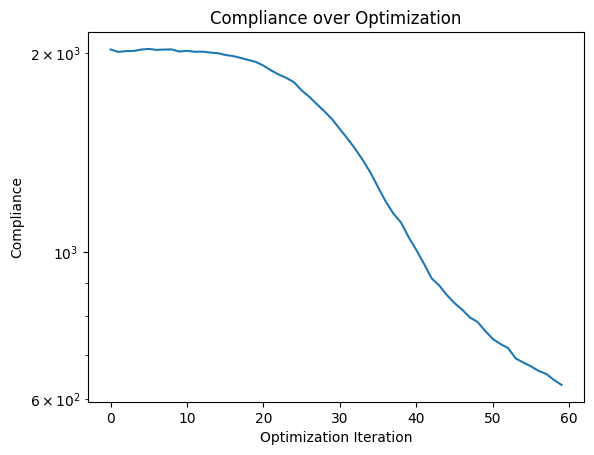

In [17]:
plt.plot(loss_hist)
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

We can also trace the y coordinates of the vertices over the optimization steps. This gives us an idea of how the design variables are changing during the optimization process.

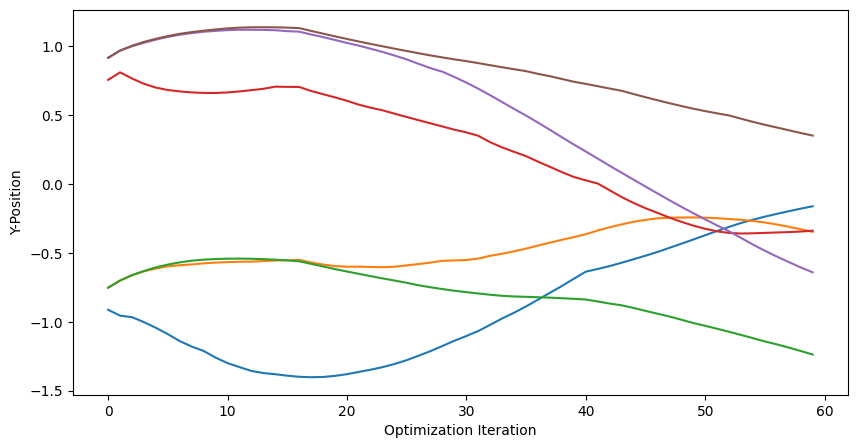

In [18]:
param_hist_tensor = jnp.array(params_hist)

plt.figure(figsize=(10, 5))

for chain in range(n_chains):
    for edge in range(n_edges_per_chain + 1):
        plt.plot(
            param_hist_tensor[:, chain, edge, 1].T, label=f"Chain {chain}, Edge {edge}"
        )

plt.xlabel("Optimization Iteration")
plt.ylabel("Y-Position");

## Step 3: Visualize results

After optimization, the structure has been adjusted to assume a more stable configuration under the given load. The design variables have been tuned to achieve this goal, reducing the compliance of the structure from around 10,000 to about 200.

Here is the final optimized structure:

We generate a video of the optimization process to visualize how the structure evolves over time.

In [19]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist:
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-3,
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow(
        rho[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1
    )
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim.gif", writer="pillow", fps=10)

In [20]:
from IPython.display import HTML

HTML(ani.to_jshtml(fps=10, embed_frames=True))

In [21]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"img/mesh_optim_{i:03d}.png")